# Deterministic model of three genes interaction network

In this example we are going to perform parameter inference for a deterministic model of three gene interaction, described in (Karlebach & Shamir, 2008). The model is illustrated by the figure below

<img src="threegeneinteractions.png" width="500" height="1000">

Apart from participating in the interactions shown on this diagram, all genes are also activated by the environment and degrade into environment (not shown). Gene 1 is repressed by Gene 3, Gene 2 is activated by Gene 1, and Gene 3 is activated by both Gene 1 and Gene 2.

Using Michaelis-Menten kinetics, we can produce the following system of diferential equations for this system:

$$
\begin{align*}
\frac{dx_1}{dt} &= k_{1,a}\frac{1}{1+k_{3,1} x_3} - k_{1,d} x_1\\
\frac{dx_2}{dt} &= k_{2,a}\frac{k_{1,2} x_1}{1+k_{1,2} x_1} - k_{2,d} x_2\\
\frac{dx_3}{dt} &= k_{3,a}\frac{k_{1,3} x_1 k_{2,3} x_3}{(1+k_{1,3} x_1)(1+k_{2,3} x_2)} - k_{3,d} x_3
\end{align*}
$$

Here, for $i, j \in \{1, 2, 3\}$, $x_i$ denote concentrations of respective genes, as they change with time; $k_{i, a}$ are the rates with which Gene $i$ is activated by the environment; $k_{i, d}$ are the rates with which Gene $i$ degrades into the environment, and $k_{i, j}$ is the rate with which Gene $i$ activates or represses Gene $j$.

### References
- Toni, T., Welch, D., Strelkowa, N., Ipsen, A., & Stumpf, M. P. H. (2009). Approximate Bayesian computation scheme for parameter inference and model selection in dynamical systems. *Interface*, (July 2008), 187–202. https://doi.org/10.1098/rsif.2008.0172
- Karlebach, G., & Shamir, R. (2008). Modelling and analysis of gene regulatory networks. *Nature Reviews Molecular Cell Biology*, 9(10), 770–780. https://doi.org/10.1038/nrm2503


# To run this notebook locally:
* Make sure that [Jupyter](https://jupyter.org/) is installed, along with [Julia](https://www.julialang.org/) and its [Jupyter Kernel](https://github.com/JuliaLang/IJulia.jl).
* Clone or download [GpABC.jl](https://github.com/tanhevg/GpABC.jl) to your machine.
* Run `jupyter` from the `examples` directory of the local copy of `GpABC.jl`:
```bash
$ cd GpABC.jl/examples
$ jupyter notebook abc-examples.ipynb
```
* The first line of the cell below activates the local project environment and downloads all the dependencies.

This notebook was tested under Julia 1.7.2

In [1]:
ENV["PYTHON"]=""; import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
using GpABC, OrdinaryDiffEq, Distances, Distributions, Plots, StatsBase, Printf
pyplot()

  Activating project at `~/gaussian_processes/GpABC.jl/examples`


Plots.PyPlotBackend()

# Rejection ABC using `GpABC` - estimating parameters

Let's start by implementing the above system of ODEs (model of three genes interaction network) in Julia, and setting up some scaffolding for the ABC computations. The ABC computations will need the user to specify some priors for the parameters they wish to estimate.

The user also needs to specify a function that simulates the model (named `simulator_function` in the cell below) that needs to take the parameters the user wishes to estimate, the variable/non-fixed parameters, and return the ODE solution.

In [2]:
#
# ABC settings
#
true_params =  [2.0, 1.0, 15.0, 1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0] # nominal parameter values
priors = [Uniform(0.2, 5.), Uniform(0.2, 5.), Uniform(10., 20.),
          Uniform(0.2, 2.), Uniform(0.2, 2.), Uniform(0.2, 2.),
          Uniform(75., 125.), Uniform(0.2, 2.), Uniform(0.2, 2.), 
          Uniform(0.2, 2.)]
param_indices = [1, 3, 9]  #indices of the parameters we want to estimate
priors = priors[param_indices]

#
# ODE solver settings
#
Tspan = (0.0, 10.0)
x0 = [3.0, 2.0, 1.0]
solver = RK4()
saveat = 0.1

#
# Returns the solution to the toy model as solved by OrdinaryDiffEq
#
GeneReg = function(params::AbstractArray{Float64,1},
    Tspan::Tuple{Float64,Float64}, x0::AbstractArray{Float64,1},
    solver::OrdinaryDiffEq.OrdinaryDiffEqAlgorithm, saveat::Float64)

  if size(params,1) != 10
    throw(ArgumentError("GeneReg needs 10 parameters, $(size(params,1)) were provided"))
  end

  function ODE_3GeneReg(dx, x, par, t)
    dx[1] = par[1]/(1+par[7]*x[3]) - par[4]*x[1]
    dx[2] = par[2]*par[8]*x[1]/(1+par[8]*x[1]) - par[5]*x[2]
    dx[3] = par[3]*par[9]*x[1]*par[10]*x[2]./(1+par[9]*x[1])./(1+par[10]*x[2]) - par[6]*x[3]
  end

  prob = ODEProblem(ODE_3GeneReg, x0 ,Tspan, params)
  Obs = solve(prob, solver, saveat=saveat)

  return hcat(Obs.u...)
end

#
# A function that simulates the model 
#
function simulator_function(var_params)
    params = copy(true_params)
    params[param_indices] .= var_params
    GeneReg(params, Tspan, x0, solver, saveat)
end

simulator_function (generic function with 1 method)

## Plot reference data

The final scaffolding for the ABC computation that is left to be set up is establishing the reference data, $\mathcal{D}$, which is the gene levels over time. In this example the reference data, $\mathcal{D}$, will be "fake" data for the purpose of setting up an example used for parameter estimation where the true parameter values are known. This is computed by solving the model (`GeneReg`) with the true parameters defined in the above cell.

During parameter estimation using real-life or experimental data, the reference data, $\mathcal{D}$, would be need to be changed from simulated data to the experimental data. This is done through redefining your reference data.

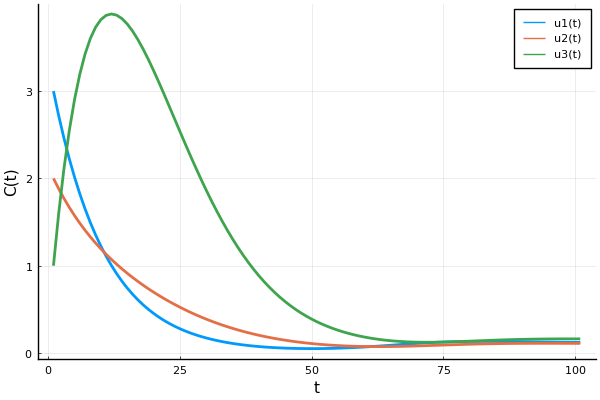

In [3]:
#
# Get reference data and plot it
#
reference_data = simulator_function(true_params[param_indices])
plot(reference_data', xlabel="t", ylabel="C(t)", linewidth=2, labels=["u1(t)" "u2(t)" "u3(t)"])

## Simulation-based rejection ABC

The intuition beind [rejection ABC](https://tanhevg.github.io/GpABC.jl/latest/overview-abc/#Simulation-based-Rejection-ABC-1) is the following: simulate the ODE for different parameter values sampled from your priors and only accept the parameter combinations that produce ODE simulations *close enough* to your reference data, $\mathcal{D}$. The accepted combinations of parameters serve as an approximation to your posterior of your parameters.

`GpABC.jl` provides two algorithms for rejection ABC: simulation-based and emulation-based. 

Here we begin by demonstrating simulated rejection ABC, by calling [`SimulatedABCRejection`](https://tanhevg.github.io/GpABC.jl/latest/ref-abc/#GpABC.SimulatedABCSMC) function. The simulator function will be called on every step of the  ABC procedure. 

The plot recipe makes it easy to visualise the results. As one can see, after just one iteration of rejection ABC the posterior population does not highlight the true parameters very well. Still, the simualtion ABC results will always serve as the "gold-standard" for the emulation ABC results.

┌ Warning: Keyword argument letter not supported with Plots.PyPlotBackend().  Choose from: annotations, arrow, aspect_ratio, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_edges, bar_position, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_tickfontcolor, colorbar_tickfontfamily, colorbar_tickfonthalign, colorbar_tickfontrotation, colorbar_tickfontsize, colorbar_tickfontvalign, colorbar_ticks, colorbar_title, connections, contour_labels, contours, discrete_values, dpi, fill_z, fillalpha, fillcolor, fillrange, flip, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_guide, foreground_color_subplot, foreground_color_text, foreground_color_title, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guide_position, guidefontcolor, guidefontfamily, guidefontsize, html_output_format, inset_subplots, label, 

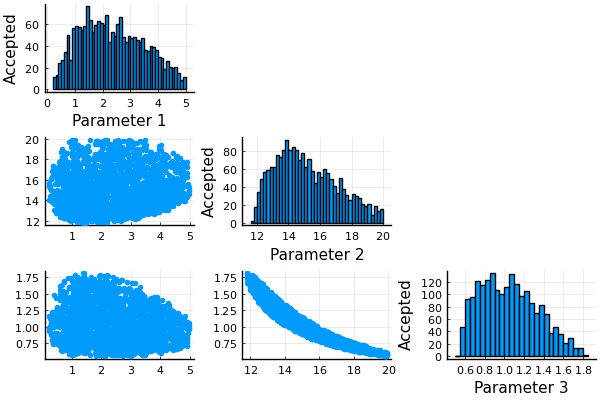

In [4]:
#
# Simulation
#
n_particles = 2000
threshold = 1.0
sim_result = SimulatedABCRejection(reference_data, simulator_function, priors, threshold, n_particles;
    max_iter=convert(Int, 2e6),
    write_progress=false)
plot(sim_result)

One of the more important choices to be made in the ABC algorithim is the maximum number of iterations. This is the `max_iter` argument to `SimulatedABCRejection` and controls the maximum number of parameters for which the model will be simulated.

If this number is too low then the posteriors will contain too few particles. In fact, the algorithm may terminate before `n_particles` are accepted : `GpABC` will print a warning in this case.

A very high value for `max_iter` is only a problem if a very small number of particles are being accepted (which can happen if `threshold` is too small, for example). In this scenario the ABC algorithm will run for an extremely long time (the exact time depends on the computational cost of the simulator).

The case when `max_iter` is too small is shown below (3,000 vs 2,000,000 in the plot above). These posteriors suggest there is low probability in regions that would be filled with packages where `max_iter` a larger value.

┌ Warning: Simulation reached maximum iterations 3000 before finding 2000 particles - will return 210
└ @ GpABC /data/.julia/packages/GpABC/o0EN1/src/abc/rejection.jl:92


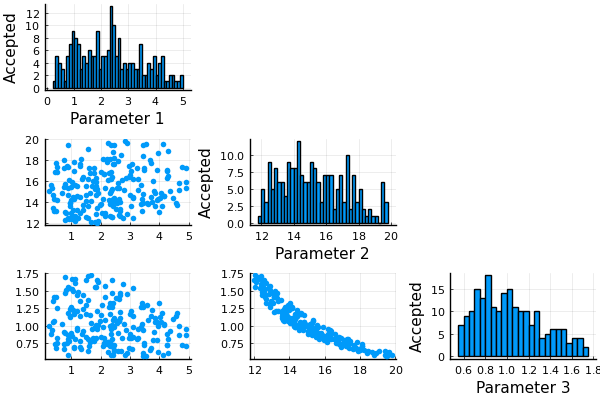

In [5]:
#
# Simulation with max_iter set too low
#data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAlgAAAGQCAYAAAByNR6YAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAA9hAAAPYQGoP6dpAACg9UlEQVR4nOzdeXxTVfr48c9NurIVugDFUkqFFpClBUE2WUVGVECKM64QFMEFkZFhEOU74m+0MoooLmBVBnVYBgXcGRWQVZDFArKUpUBpkRQoYBUopUnu74+Q0LRJmrTZ2j7v14sXae7NPSfLbZ6ec+7zKKqqqgghhBBCCI/R+LsDQgghhBA1jQRYQgghhBAeVu0CrEuXLpGZmcmlS5f83RUhhBBCCLuqXYB14MABunTpwoEDBygsLPRp2zW5vZr83PzRnhBCiNotyN8dqAqj0Vgr2tPr9ej1egCio6OJj4/3Wlu+UtPbE0IIUbtV6wCrNtDr9TRr1sz6c1h4HQ4eyPJKkCWEEEIIz6h2U4S1jWXkigffhYc/5HLRJTZu3EhmZia5ubn+7ZwQQggh7JIRrOoiPhX+KADggQceAGQ0SwghhAhUMoJVnVwwB1ilR7MKCgr82ychhBBClCMjWNVRfKq/eyCEEEIIJ2QESwghhBDCw2QEK8CUTskQFCRvjxBCCFEdyTd4ACmbkiE0vA7LP/3Ejz0SQgghRGVIgBVAbFIyhIRRPF/Hb7/9VqXjeTtBqRBCCCHKswmwNmzY4NaD+/Tp49HO1CRVCm48sIhdEpQKIYQQ/mMTYPXr1w9FUVBVFQBFUazbVFW1+RncKz9SXFzM5MmT+e677wgLC6NTp04sXLgQgMOHDzN69GgKCgqIiIjgww8/5IYbbqj0k/K3QAhuyo6GXZ6vo6CgQAIsIYQQwgdsAqydO3dab58+fZqHH36Y/v37M3LkSJo0acKpU6f49NNPWbduHfPnz3eroWeeeQZFUTh06BCKopCfn2/dNn78eMaNG4dOp2PZsmXodDq2b99exafmPwEV3EhKByGEEMLnbAKsTp06WW+PHDmSe+65h1deecXmAXfeeSdTpkxh3rx5DBo0yKVGLl68yPz58zlx4oR1FKxp06aAOZDbsWMH33//PQBpaWlMmDCB7OxsWrVqVflnFghcDG4s04lZWVmVbspyDFlrJYQQQvifw0Xu3333HStWrLC77dZbb2XEiBEuN3LkyBEiIyNJT09n9erVhIeHM2PGDAYOHEheXh6xsbHWlASKohAfH09ubq7TAGvChAmEh4dzzz33kJaW5nJfquL8+fMu7VdYWFjuvu3bt1NYWEhUVBRxcXHW+/Pz851Oh164cKHCtvbv3289Rmh4Hbb9tMVuHwoLCzl37pzd47j63Dwl0NqLjIz0UU+EEELUBg4DrHr16rFmzRq7o1SrVq2iXr16LjdiMBg4fvw47dq1Y+bMmezcuZNBgwaxb9++yvUaePvtt0lISPD5F6Mr7UVERFz74Wr9wEcffRQovx4rJyfHvN+D78Lv+fDFDJtjVfQ6R0REcPnyZfMPgyZRvOoNDAaDbR9K7eus/4H4Wlbn9oQQQtReDgOsJ554gn/84x+cOnWK4cOH07hxY06fPs1nn33Gf/7zH1544QWXG4mPj0ej0XD//fcDkJqaSsuWLdmzZw8dO3ZEr9djMBgICgpCVVVyc3NrzjRX6fqBztZjxaeC/oDbh7eZVmzapgoddZ2kfxBCCCGccxhgTZ8+nYYNGzJz5kw++ugj69WFsbGxvPHGGzz55JMuNxIdHc3AgQP57rvvGDJkCMeOHePYsWO0bduWxo0b07lzZxYuXIhOp2P58uXExcVVq/VXLq1/8vRi86sjYw888IDLD7EEY1UJigLhCkkhhBAi0DlNNDphwgQef/xxTpw4gV6vJzY2lri4ODQa90sYvvvuuzz88MNMnToVjUZDRkYG1113HQAZGRnodDrS09Np0KABCxYsqNyz8YPSAYcl2HD1cVVa2F56ZKzM1GK5Y5YJxioKipyNUAXUFZJCCCFEgKowk7tGoyE+Pr7KX6CJiYmsXbvW7rbk5GS2bNlSpeP7izXgGDSJy6veYOPGjRU+5syZM3Tp0sUzHSg9tXjJvLC93KiWq9OUuDFCJekfhBBCCIecDkXt27ePe+65h+uvv57Q0FAyMzMBeO655/jf//7nkw76m16vJzMzk8zMTE6cOOF4xwaxgDm4qWjarqCgVMAzbIaHegoUFTo/bnwqNG3r9BA2I1QPf8jlokvX+iuEEEIIlzgcwVq1ahW33347Xbp04f777+fFF1+0bgsODmbu3LncdtttPumkr5SdGgsODi5XfPmQo6m10sGNnasBSzt27Jj5hgsL2637usONBfOW5xwUFGR7lZ2MUAkhhBCV5jDAmjZtGvfccw8ff/wxBoPBJsBKTU3lgw8+8EkHfcXe1NiyTz8x/1Cq+HKF642cBTdX10L93//9X8UdcmffSir9nC3BoxBCCCGqzuEU4d69e3nwwQcBytUgbNiwYY2bNrI3NWYtHeTC1JpLLGuhbrrPs/tWUun1Y8UyFSiEEEJ4jMMRrMjISE6ePGl326FDh4iNjfVap/wqPtWl0aMqXQUYleCdfSvLR/mzhBBCiNrCYYA1fPhwnn/+ebp3727NSWUp0jxr1iyflafxi9KjR1sXl9tcdjpRCCGEEKI0h1OEL7/8MjExMXTs2JGbbroJgIceeojk5GQiIiKYMWOGr/roPw5Gj2ymEz15FaAQQgghagSHI1gRERFs3ryZhQsXsmrVKiIjI4mMjOSJJ55g1KhRhISE+LKfgamS5W2EEEIIUbM5TTQaHBzMmDFjGDNmjK/6I4QQQghR7TmcItRqtWzbts3utp9//hmtVuu1Tgnvy8rKqnyZHiGEEEI45XAES1VVhw8yGAwSYFVXlSgSLYQQQgj32ARY+fn5NqkZDh48SFCQbQx2+fJl/v3vf9OiRQvf9FB4lpMi0UIIIYTwDJvoKSMjgxdeeAFFUVAUBZ1OV+4Bqqqi1WqZO3eur/oovMHOAn2ZMhRCCCE8wybA0ul09OvXD1VVGTBgAO+88w7t2rWzeUBISAhJSUlERUX5tKPCiy6Z6yjKtKEQQgjhGTYBVosWLaxTf2vXrqVz587Ur1/fLx0TPuRGoWp7LCNf0dHRzus0CiGEELWEw6sI+/btS/369Tl06BALFy7k1VdfZeHChRw8eLBKDS5YsABFUfj888+t9x0+fJiePXuSlJRE165d2bdvX5XaEJUUnwpRLV3fv9SC+S5dupDcpi25uble6pwQQghRfTi8ivDixYs88sgjfPLJJ5hMJsLCwrh8+TIajYa7776b999/n3r16rnVWE5ODu+//z7du3e3uX/8+PGMGzcOnU7HsmXL0Ol0bN++vXLPSPhO6QXzIWFcnq+joKBARrGEEELUeg5HsCZMmMDXX3/N+++/T2FhIZcuXaKwsJD33nuPb775hieffNKthkwmE2PHjuWtt94iNDTUev/p06fZsWOHdf1PWloaeXl5ZGdnV/IpeZfkj7IjPhWatvV3L4QQQoiA4XAEa/ny5fzrX/+yyeJev359HnroIS5fvsy0adNYsGCByw3Nnj2bXr160aVLF5v78/LyiI2NtaaDUBSF+Ph4cnNzrUWm7ZkwYQLh4eHcc889Hik8XVhY6HyHWpw/qrCwkHPnzpGfn1/hyKJlX4v8/HxOnToFQFRUFHFxcQCcP3/eex22o6L2IiMjfdQTIYQQtYHDACssLIyWLe2vx0lMTCQ4ONjlRvbu3cvy5cvZsGGD+z104O233yYhIcFjX4wRERHOd6jF+aMiIiIoLi7mhhtucGlfy3ui1+ttHhMWXoeDB7KsU4i+DmokiBJCCOErDqcIx4wZw7x588pldFdVlblz57pVn3Djxo3k5OTQunVrEhIS+Omnnxg3bhzz5s2jefPm6PV6DAaD9fi5ubmBu47H3YXgNYRerzffuOk+9x/z4Lvw8IdcLrpEQUGBF3onhBBCBBaHI1iRkZFkZmbSunVr7rzzTho3bszp06f56quvKC4upnfv3syePRswT+v99a9/ddjIY489xmOPPWb9uV+/fkyaNInhw4cD0LlzZxYuXIhOp2P58uXExcU5nR4UfhSV4P5j4lM93g0hhBAikDkMsKZNm2a9PWfOnHLbn3nmGevtigKsimRkZKDT6UhPT6dBgwZure0SQgghhAg0DgMsk8nktUbXrVtn83NycjJbtmzxWntCCCGEEL7kMMASwsKdtBSls7oLIYQQtZXTAKukpIT58+ezfft28vLyeOedd2jdujVLly6lY8eOtG0ruY9qNHdSU5TZNyy8Dss+/cRrXRNCCCECmcMA6+jRo9xyyy0UFBSQmprKpk2b+OOPPwDYsGED3377rayVquncSU1hJ6v7b7/95lZzer3eeuWh1DUUQghRnTkMsCZOnEhMTAzbtm2jYcOGhISEWLf17dvXZhF8dWb5Upfs7E7Ep4L+gOv7XnXs2DGXm9Dr9TRr1sz6c9mcWUIIIUR14jDAWrduHUuWLCE6Ohqj0WizrWnTptdyHFVjZb/UhYdcnS78v//7P4e75Ofnk5OTA5hHq6z5saSuoRBCiBrAYYAVFBRULsmoxalTp9wu9ByIbBJh1rLs7F5lmS686T7YurjcZnsZ3q3rtSRnlhBCiBrAYSb3vn378tprr1FSUmK9T1EUVFXlvffeY+DAgT7poDfo9XoyMzOvTQvW0uzsXucgKam9DO/urtcSQgghApnDEax//etf9OzZk3bt2jF06FAUReGdd95h7969HD58mG3btvmynx4j04IBREarhBBC1FAOR7DatGnDzz//TM+ePVmyZAlarZavv/6aVq1asW3bNq6//npf9tNjbEZPhs3wa1+EEEIIUTM5zYPVsmVLPvroI1/1xbfcuTJOCCGEEMINDgOsP/74gwsXLhAbG1tum16vp379+tVqobukYwgM8voLIYSoDRwGWGPHjqV+/fp88MEH5bY9//zzXLhwgcWLy18hFohk3VUAqCArvL2cWaXL7ki6BiGEENWJwzVYGzZs4Pbbb7e7bciQIaxfv95rnfI0WXcVAEpnei/9HtjLmVUqGOvSpQvJbdqSm5vro44KIYQQVecwwDp//jz169e3u61u3bqcPXvWa53yGknH4H9l34PSObPK3lcqjYM1EakQQghRDTgMsBITE1m9erXdbWvWrCEhIcHlRi5fvszw4cNJSkqiU6dODBo0iOzsbOv2w4cP07NnT5KSkujatSv79u1z/RmImsFezqz4VGgqBcWFEEJUPw4DrLFjxzJ79mxeeeUV6+hBQUEBr776Kq+//jqPPPKIWw2NGzeOgwcPsnv3boYNG8bYsWOt28aPH8+4ceM4dOgQU6dORafTVe7ZiBorKyuLzMxMmSoUQghRLTgMsP7617/yyCOPMG3aNJo0aUJoaChNmjThmWeeYezYsUyePNnlRsLCwhgyZAiKogDQvXt3ax2606dPs2PHDuvi57S0NPLy8mxGuEQtJuuxhBBCVEMOryK0ZG6fNGkSP/zwA2fPniUqKooBAwbQunXrKjU6Z84chg0bBkBeXh6xsbEEBQVZ242Pjyc3N5dWrVo5PMaECRMIDw/nnnvuIS0tzWl7hYWFVeqv8KML5YtAHzlyxO0UIefPn3e6PTIysrI9FEIIIcpxmmgUoHXr1lUOqEpLT08nOzubNWvWVOk4b7/9NgkJCS59MUZERFSpLREASpXViYiIqFRAJEGUEEIIX3E4Rbh06VJeffVVu9tmzZrFp59+6nZjs2bNYsWKFfzvf/+jTp06ADRv3hy9Xo/BYABAVVVyc3Ml75EQQgghqi2HAdbMmTMJDQ21uy08PJyZM2e61dDs2bNZsmQJq1atomHDhtb7GzduTOfOnVm4cCEAy5cvJy4uzun0oBB6vZ7MzExZ+C6EECIgOZwiPHToEO3bt7e7rV27dhw6dMjlRk6cOMHkyZNJTEykf//+AISGhrJ161YAMjIy0Ol0pKen06BBAxYsWODOcxC1zJkzZ+jSpYv157DwOhw8kCWjnkIIIQKGwwArLCyMU6dO2d2m1+uti9JdERcXh6qqDrcnJyezZcsWl48najdr0tFSC98LCgokwBJCCBEwHE4R9u3bl5kzZ3Lx4kWb+y9evMgrr7xCv379vN03IZwrlYhU8mQJIYQIJA6HodLT0+nRowfXX389I0eOpFmzZpw8eZJly5ZRXFzMf//7X1/2Uwj7yhSRlulCIYQQgcBhgNWmTRu2b9/O888/z/Lly615sAYNGsSMGTPQaBwOfgUUvV5PVlaWv7shPOjYsWPXfrCTJ2vjxo20bduW6OhoCbSEEEL4hdOFVK1atWLRokXWn8+cOcMnn3zCqFGj+OmnnzAajV7vYFXo9XqaNWvm724IT7k6WvV///d/5bfFp8polhBCiIBR4TDUpUuXWLRoEbfffjtxcXFMnDiRy5cv8/rrr/uif1Wi1+vNN266z78dEZ5hGa1y9H6WHs16+EMuF126tiBeCCGE8CG7I1hGo5Fvv/2WxYsX8+WXX3Lx4kViY2MxGAwsWbKEP//5z77uZ9VEJfi7B8KTKno/S2V9F0IIIfzBJsD68ccfWbx4MZ9++ikFBQVERUXxwAMPcN9999G+fXuioqJo2rSpv/oqhBBCCFEt2ARYN998M4qi0L9/f55++mluvfVWa74rKZgshBBCCOEamwCrQ4cO7Nmzh/Xr16PVaikoKOCuu+6ifv36/uqfEEIIIUS1Y7PIfffu3ezdu5cpU6Zw+PBhdDodTZs25c9//jNffPEFiqL4q59CVIolAemJEyf83RUhhBC1SLmrCNu1a0d6ejpHjx5l48aN6HQ61q9fj06nA2DOnDls2LDB1/0Uwj2lUjZ06dKFbt17SJZ3IYQQPuM0TUOvXr145513OHnyJF9//TX33Xcfq1aton///iQmJvqqj0K4r0zKhmJJ2SCEEMKHXKrYrNVqGTJkCEOGDKGoqIjPP/+cJUuWeLtvQlSdpGwQQgjhB27XuwkPD+fee+/lyy+/9EZ/hBBCCCGqvYApKHj48GF69uxJUlISXbt2Zd++fZU+ll6vJzMzU2oQCiGEEMIvXJoi9IXx48czbtw4dDody5YtQ6fTsX37drePI/UHhRBCCOFvATGCdfr0aXbs2GEt0puWlkZeXh7Z2dluH8taf3DQJOg9xnz796v35WfB2WOu33bncdVt30DrjzefZ76MZAohhPAtRVVV1d+d+Pnnn7nvvvs4ePCg9b5u3boxc+ZMBgwYYLNvZmYmXbp0oUePHvz+++889dRTpKWlWbefOHGCbt17UFx0yXyHogHVdO3/0ve5crsm7xto/fHi8wwKCeXn7duIi4vDnsjISLv3CyGEEJURMFOE7nr77bd57rnneOSRR2zuj4yM5NCBLOsl+cXFxYSGhlr/L32fK7dL3/f4448zd+5cl/Z157iOblva8/Rx7d2u6Ll5+nnaa8+bz/Ppp5+mY8eOCCGEEL4QEAFW8+bN0ev1GAwGgoKCUFWV3Nxc4uPjy+1bVFQEmDN0FxYWkpmZ6fTYli9Yy//u3i59n0ajcXlfd47r6LalPU8f197tip6bp5+nvfa8+TyvXLlS4WelTZs21KlTx+k+QgghhCsCYooQoF+/fuh0Ousi95kzZ7Jjx45y+y1atMi6VksIT/r555/p3Lmzv7shhBCiBgiYAOvgwYPodDrOnj1LgwYNWLBgAR06dCi3X0FBAd999x0JCQmEh4f7oaeippIRLCGEEJ4SMAGWEEIIIURNERBpGoQQQgghahIJsIQQQgghPEwCLCGEEEIID5MASwghhBDCw6plgOXJwtCumDhxIgkJCSiKwq5du7za1uXLlxk+fDhJSUl06tSJQYMGVapkkKtuvfVWOnbsSEpKCjfffDM7d+70WlulLViwAEVR+Pzzz73aTkJCAsnJyaSkpJCSksLSpUu92p4QQggB1TTAshSGPnToEFOnTkWn03m1vZEjR7Jp0yZatGjh1XYsxo0bx8GDB9m9ezfDhg1j7NixXmvrk08+4ZdffmHXrl08/fTTXn8tAXJycnj//ffp3r2719sCWLp0Kbt27WLXrl385S9/8UmbQgghardqF2B5sjC0q/r06eOwhp2nhYWFMWTIEBRFAaB79+7k5OR4rb2GDRtabxcWFlrb9RaTycTYsWN56623bDKtCyGEEDVJQJTKcUdeXh6xsbEEBZm7rigK8fHx5Obm0qpVKz/3zvPmzJnDsGHDvNrGqFGjWLt2LQArV670aluzZ8+mV69edOnSxavtlDZq1ChUVbUWEI+JifFZ20IIIWqnajeCVZukp6eTnZ3Nyy+/7NV2Pv74Y/Ly8njxxReZOnWq19rZu3cvy5cvZ/r06V5ro6wNGzbwyy+/kJmZSXR0NKNHj/ZZ20IIIWqvajeC5U5h6Ops1qxZrFixgtWrV/usfMvo0aN59NFHOXv2LFFRUR4//saNG8nJyaF169YA5OfnM27cOPR6PY899pjH2wOsn4vg4GAmTZpEUlKSV9oRQgghSqt2I1iNGzemc+fOLFy4EIDly5cTFxdXo6YHZ8+ezZIlS1i1apXNGilP++233zh58qT1588//5yoqCgiIyO90t5jjz2GXq8nJyeHnJwcunfvznvvvee14OrixYv89ttv1p+XLFlCamqqV9oSQgghSqt2I1gAGRkZ6HQ60tPTrYWhvWn8+PF888035OfnM3jwYOrXr++1RfUnTpxg8uTJJCYm0r9/fwBCQ0PZunWrx9sqLCzk7rvvpqioCI1GQ0xMDF9//bXXF7r7yqlTp0hLS8NoNKKqKomJiXz88cf+7pYQQohaQIo9CyGEEEJ4WLWbIhRCCCGECHQSYAkhhBBCeJgEWEIIIYQQHiYBlhBCCCGEh0mAJYQQQgjhYRJgCSGEEEJ4mARYLpgxYwaKolj/xcTEMGDAADZu3OjvrnnUunXrSE9P90lbO3bsYMyYMbRt2xaNRsMdd9zhk3aFEEIIX5AAy0Xh4eFs2bKFLVu2MG/ePM6ePcvAgQPZu3evv7vmMb4MsH788Uc2btxI586da1yZIyGEEEICLBdpNBq6d+9O9+7dGTlyJF999RUGg4F333230sdUVZXi4mIP9jKwFBUVOdz25JNPkp2dzaJFi0hISPBdp4QQQggfkACrkuLj44mJieHYsWMAvPbaa3Tt2pWIiAgaN27MHXfcwaFDh2weo9PpaN++PStXrqRTp06Ehoby1VdfcfHiRSZMmEBycjJ16tQhISGBRx99lMLCQpvHJyQkMGHCBN544w2aN29O/fr10el0FBcXs2vXLnr16kXdunXp1q0be/bssXmsqqrMmjWLpKQkQkNDSUxM5PXXX7dunzFjBi+88AIXL160ToX269fPuj0rK4thw4YRERFB3bp1uf322zly5IhNG4qiMHPmTKZOnUrTpk1p3Lixw9dPo5GPnhBCiJqrWtYiDAS///47Z8+epVmzZoC5huCECRNo0aIFv//+O++++y49e/bk0KFDNsWTT548ycSJE5k+fTrx8fHEx8dz6dIljEYjL730EjExMeTl5fHSSy8xfPhw1q5da9PuF198Qfv27cnIyODo0aM8/fTThISEsGXLFp5++mmaNGnC1KlTufvuu9m/f781kHnqqaf44IMPeO6557jpppvYvHkzU6dOJTw8nEcffZSxY8dy4sQJFi9ezA8//ABAgwYNADh69Cg9e/akffv2fPjhh2g0Gl566SUGDhzIwYMHCQ0NtfZvzpw5dO/enfnz52MwGLz6HgghhBABSxUVev7559W6deuqJSUlaklJiXrs2DF1xIgRKqB+++235fY3GAzqpUuX1Hr16qkZGRnW+0ePHq0C6k8//eS0vZKSEnXTpk0qoB48eNB6f4sWLdS4uDi1uLjYel9aWpoKqP/73/+s93311VcqoO7atUtVVVXNzs5WFUWx6YuqqurUqVPVpk2bqkaj0eZ5ljVq1Cg1MTFRLSoqst53+vRptV69euo777xjvQ9Q27Vrp5pMJqfPr6y+ffuqt99+u1uPEUIIIQKZzNO46OLFiwQHBxMcHEzLli1Zu3Ytb7/9NoMHDwbgp59+YtCgQURFRREUFESdOnW4cOFCuWnCqKgobrrppnLH/89//kNqair16tUjODiY3r17A5R7fN++fQkJCbH+nJSUhEajYcCAATb3AeTl5QGwevVqANLS0jAYDNZ/t9xyC/n5+db9HPn+++8ZOnQoQUFB1sc2atSI1NRUtm/fbrPvbbfdhqIoTo8nhBBC1HQyReii8PBwNmzYgKIoREdH07x5c+v0W25uLrfeeis33ngjGRkZNGvWjJCQEG6//XYuX75sc5wmTZqUO/Znn33GqFGjGDduHC+99BJRUVHo9Xruuuuuco9v2LChzc8hISGEh4fbBF2W25bHFhQUoKoq0dHRdp9bXl4eLVq0cPjcCwoKeOONN3jjjTfKbSvdrqPnJ4QQQtQ2EmC5SKPRcOONN9rd9u2333LhwgVWrFhhDYAMBgPnzp0rt6+90Z1PP/2UlJQUMjIyrPetX7/eMx0HIiMjURSFTZs2lQuIAJKTkyt8/O23387jjz9eblv9+vVtfpbRKyGEEEICLI8oKipCURSCg4Ot933yyScuL/IuKioqF/gsWrTIY/0bOHAgAGfPnuXOO+90uF9ISIjdtBG33HILe/fuJTU1Fa1W67F+CSGEEDWVBFgeYFn/NGbMGMaPH8++fft47bXXyk3nOTJo0CCeeOIJ/vnPf9KjRw9WrlzJmjVrPNa/pKQknnjiCR588EGmTJnCTTfdRElJCYcOHWLt2rV8/vnnALRt2xaDwcCcOXPo2bMnDRo0IDk5mRdeeIGuXbsyePBgxo0bR5MmTcjPz2f9+vXcfPPN3HvvvW736cyZM9ZRujNnznDhwgWWLVsGwJAhQ6hTp47Hnr8QQgjhaxJgeUCHDh348MMPmTFjBnfccQcpKSksW7aMu+++26XHjx8/nqNHj/LWW2/x6quvMnjwYBYvXkz37t091sc333yT5ORkMjIy+H//7/9Rr149kpOTbfp455138vjjj/Pyyy9z+vRp+vTpw7p162jVqhXbtm1j+vTpPP7441y4cIHY2Fj69OlDx44dK9Wfffv2lXt9LD8fO3ZMko8KIYSo1hRVVVV/d0IIIYQQoiaRNA1CCCGEEB4mAZYQQgghhIdJgCWEEEII4WESYAkhhBBCeJgEWEIIIYQQHiYBlhBCCCGEh0mAJYQQQgjhYRJgCSGEEEJ4mARYQgghhBAeVu0CrEuXLpGZmcmlS5f83RUhAoKcE0IIEXh8EmBdvnyZ4cOHk5SURKdOnRg0aBDZ2dnW7YcPH6Znz54kJSXRtWtX9u3b5/BYBw4coEuXLhw4cMAXXaewsLBSjztTpLLmVxNZ502s+dXEmaKKKxJZHnPkVOXadPX4jvpS2edaFf5o05/tekNVzwl/vhb+fh9qc/v+fu5C1HQ+G8EaN24cBw8eZPfu3QwbNoyxY8dat40fP55x48Zx6NAhpk6dik6n81W3KmQ0Gt1+TEaWkbjFBm5ZaaTdMiO3rDT/nJHl+Fg2j/k63Om+7jpTpPLXLQauW2Rw2pfKPNeKgraKVKZNT/BXu4HIn6+Fv9+H2ty+v5+7EDWdTwKssLAwhgwZgqIoAHTv3p2cnBwATp8+zY4dO3jggQcASEtLIy8vz2aEq7o4U6Sy/KiRJ380ccVku+2KCZ7aYj8QOVOkMnHztcdcMSkO97XsX1FQY9ln1m5zQPXGXpUStVRfNlc+KLIc35WgTYiy9Ho9mZmZZGZmcuLECX93RwghvCLIH43OmTOHYcOGAZCXl0dsbCxBQeauKIpCfHw8ubm5tGrVyuExJkyYQEREBCNGjCAtLc1jfSsoVthXqOGGCBPRoSrnz5+vcB+AD48GM213KFdMisNjFxvhx+O/06exbSCy6bSWK6Y6Lu1bup0QjcrLnYrRJZY43AdUoHyfik0w5cdLDIszOH2u9nx4NJhndodSUuq5XjHBxM1GQksu0DPm2utSEVfb9LSy7UZGRvqlH7WNXq+nWbNm1p9Dw+tw6EAW8fHxfuyVEEJ4ns8DrPT0dLKzs1mzZk2VjvP222/TuXNnD/XKLCPLaB1JCtHAmz013N3E9svX3j59mio8s9tIicnJwYEgBXonNCAyzDbg6R2uEvKjwWbUK1Rr3teowi/nVJrVgf3nVZ7ZZSo1EqXw7O4wHryhHjHh5mOeKVKZtrv0sRwHfB8dC+GjYyEOn6tF1nkTX+eq3BGvEB2mMG23we5zvWJSGLO1jvV449tqrdvOFKn8ck6lY6Ri7auFv4IbCap8T6/Xm288+C6EhFE8X0dBQYEEWEKIGsenAdasWbNYsWIFq1evpk4d84hN8+bN0ev1GAwGgoKCUFWV3Nxcn/7CPVOkskFv4skfTbbTaFtM9L9NIbLUfrZTeTDhRxOqCq5Ojql2BnZiwhWmdVJ4cZeKUYVQjcqcHlqWHzPZtGdPsQnSdxl5vYf5rfzlnOp0f3vsPVeL+38wsPiIudN/3wYDYqnw+JbjjUjQEBOuMGu3kWd3mCgpFZSWDr5ELRSf6u8eCCGEV/lskfvs2bNZsmQJq1atomHDhtb7GzduTOfOnVm4cCEAy5cvJy4uzun0oCdZFpePXHMtuLIoNsL+wmsvkb3gxeBGcGVQYc+58hHW/T8YeGGnObgCGNTUwIgETYXBlcXc/ap1PVXHSAWt40Erh8o+VzCPXFmCK4sf9OaROFeOt+ecyqxfDEzZZrKOeDlbiyaEEELUFD4JsE6cOMHkyZP57bff6N+/PykpKdx0003W7RkZGWRkZJCUlMTMmTNZsGCBL7pVbkSqrFAt3BBxbWPHSIWQKrxiQQp0jLoWnZwpUvn3AUO5IObrk0F8ddzo8kjUFZNt4FaJ+KrccwX4Otd+ENQ/1rXjNasL07aVP4Yl+BJCCCFqKp9MEcbFxaHamxu7Kjk5mS1btviiKzacTaeFamFODw1RpRZrx4QrvNlTw1NbTBRX8oI5y8tQei1XeQoHfnP9mKHaa4HbL+dUDHZe6mAN1ik6gwqmMvu8eKOCCiw/an5ifWI13BGv8Pdt5Y91RwtYddJ5f+b00PDrRRz2pVkdWPOrieaa8tOSQgghRHXnl6sIA4VlRMpmcbkGlgzQ0Lupef3QuXO2jxnfVkufpgodlhutU3quskwRdoikguk/lbh6zo9lCZgswUz01YXzHSMVghVspjtDtfDD7Ro250NkqMrDG8t3/NeL0HZrXUyYO6XBxNzeGu67XrEZYesaDVO22u9TkALv91a4vYWWmHCFM0VqudcXYPB10GmF8eqFAnV5s6eREQkah4vghRBCiOqmVgdYZUekLMHKXS2dL8A+eQm3gyswjx51jFLYfdb5QvTOjUxM2eq8D5Paw5/itHSINAcjlpGnYxdUSnctSIG0BIX+X5sDumDFfF/ZkaU5e1XUUpOLJuCJTSb0DwQxPVVlZa5K9yYw4BvHgaFBhfE/qrypmhjfVmt9fSf8aLJp7+u8a7evmBQm/HhtMX+wAk/coPBsilYCLSGEENVWrQ6wwDwiNSJBc3VkybXRE3sjX6VpFfMUXNkYzKjC8mMm/rji+NjBGtj9m6bCAO7VX2D/OSM3NoYXdzoO+BQVPjl6bdqwRLW/8M7ew43A17lGxiQH0baReUrP3nPWAJa7y15BOCJBw4RNzheTGdRrHShR4Y29KnP3GwLmasMNGza4tX+fPn1c3nflypVMnz4dk8mEwWBgypQpjB49GjCXkBo9ejQFBQVERETw4YcfcsMNN7jVFyGEEP5R6wMsMI9kdYjk6hQVNjmlNp3W0jtctQm8LCMzT2422c0HZS+4AnMQNHGz82DDfDzXRm6+OWH+5/R4UK4z7mRxeGSDytliA6lRGprVoVxgaW80rNgIG/UmIkIVfitWMbjRnoUl27wlUPOnfv36oSiKdR2hpSIBgKqqNj+D6yVIVFXlgQceYN26dXTs2JGcnBzatGnDiBEjqF+/vrWElE6nY9myZeh0OrZv3+65JxYgsrKyrLejo6MlJ5YQokaQAAv7yUPBsk6qDiE/XhtNsSTMHJGgIVixv57J2eCTuzmq/M0ITNmqAkZCNDCypWIzIqaq5YOsIAXuWWsOPoMUc7jo6DUJUVRMKHYXw1tyfD2bovXr+qydO3dab58+fZqHH36Y/v37M3LkSJo0acKpU6f49NNPWbduHfPnz3fr2Iqi8NtvvwHw+++/ExUVRWhoqLWE1Pfffw+YS0hNmDCB7Oxsn6UwqSq9Xm9NLGo0GtFqtTbBFH8UAFjLZAGEhdfhoGR2F0LUALU+wLKXPPTJTSbUUkGDZdrrjxKV57ar1kDspa6K3RGcqtJgDjp8JVgDd8bDl8dVDKrjdq+YzNONSqmIyYj5QxSqMQdEIRowmK5dpejstZnVTcOdjX9n7W8NHC76f+vqdKH1Nb9RQ2q04tNgq1OnTtbbI0eO5J577uGVV16x2efOO+9kypQpzJs3j0GDBrl0XEVRWLp0KSNGjKBu3bqcP3+eFStWEBISUqkSUpUtH+WNckX5+fkVT2deMAdYPPiuOfFofhaX5+s4cuQI9epVcJWHh/irVFMgtF9R21LpQIiqqfUBlr1UDfam1YqN5pxOpYOu6TtUXu6qYfoOE8UeGpkK8ULA5oxGMU9Lfp0LI+JKWH4ixOn6r9LrpUrf997NCmcvKwRrVCb9VPETCNXC6GQN585DqwYKu0Zomb7DxIoc28caAWOp4HfKNvMP/soI/91337FixQq722699VZGjBjh8rEMBgMvvvgiK1asoE+fPmzfvp2hQ4eyZ8+eSvWtKuWjPPVlahm1so5UPfgu/J4PX8ywvV1afCq0uJbZPSIiwqdf7v4OJPzZvr+fuxA1Wa0OsM4UqXxyxLXIyJIWobRiI3SOVsi7L4iN+SbusZMN3lUhGrjnelh4GJ+OXplKBYyf5IVU+jjjNqgYUHEW7lhew2ANvNhFc7UUUF2umMzTj9M6KazIca290ovpAZ9NIdarV481a9bYHaVatWqVWyMvu3bt4uTJk9ZF8V27diUuLo6dO3fSqVMnv5eQclfZQs6AOXjSHyh/WwghajiflcoJNBlZRq5bZOC9gxVHRMEaeCTZ/rZmdc2L3ke01PJWL02lMr0HKXBHPHx82PUF6ApwR3MqVRbHXa48JctCdkfLu0M08FyK+bmWmODZ7SYm/Gjiisn8BK6YIH23e9FpsdG8RitusYFbVpr/z8iqZAZYFz3xxBO88sorjBkzhi+++IItW7bwxRdfoNPpeO2113jiiSdcPpalDqdltCc7O5sjR46QnJzs9xJSlWFTyHnYDL/2RQgh/K1WjGBZFqZbRjgs665cGW0KVlQGX6cwN8v+9pMXoU3D8vdrry7uNqjmaTjVwZWFYN7vi+OuPRcLDfD9r/bTM1jSJpROn1AVQYq5HXdCl9JtBynmtVPP7TDZpIsoy94VmZa6h/amTUM05jqMpdfPPbXFRJ+mCicv4ZURrenTp9OwYUNmzpzJRx99ZL26MDY2ljfeeIMnn3zS5WM1adKE9957jz//+c9oNBpMJhNvv/22dZQqIyMDnU5Heno6DRo08FkJqSrzwkhV6QXzcqWhEKI6qPEB1qzdRp7dYbKWiXmzp4ZWDRSXruYL1cJTScW8khXmcLul5EuzOrbZ2Y1Xr67TUL4sTVmVmVYsvTaprGAN/CURPs52/7j2XFFhfBv48DAulwjSALc1h7SWCnfEa52WJXLmuVRI31n+/hANPN5O4Y29ti9esdGcJb70++3pdVoTJkzg8ccf58SJE+j1emJjY4mLi0OjcX/48t577+Xee++1u81fJaQCTdmpR7nSUAhRHfhsinDixIkkJCSgKAq7du2y2bZy5Uo6d+5MSkoK7du356OPPvJIm7N+MTBl27VcVVdM8ORmE0UGx9/0GuBvHeD5VIW5PRUuGuyPgCiYM6R3WmHklpVGOi4vX5zZoHpmBClYU/6NchYyFJtg0ZFKtqXY/1C8f8C8bmpSe8XlKcNv8mD8RpWPDhv5rVgl2MlgUpCDbfWCNHYD0DFJCuPa2O9JSZkRrTNFnr9qQKPREB8fz0033UR8fHylgqvqRK/Xk5mZaf2Xm5vr07YB89Tjwx9yuegSBQUFPmtfCCEqw2cjWCNHjuTvf/87vXv3trm/omSLlZV13sQz28p/sZaYYNj3jr9wTcCsPXBtQs/xwu9Pj6rWL39vXvlXYjJPOYZgHk0K0VwdFXPSprulfIIVePj6K0xMCafDcqPd5KTPbjdZb7vcd9WSR0u9NqJnZz+TnXxaoVq4o4W54HTZp/PhIZVB11X8JIuNsDHfxIgKyh+5Y9++ffzzn/9k+/btnDhxgi1bttC5c2eee+45evfuzW233eaxtgKBvcXrfhlFir92paFl3ZpMFwohApXP/uzu06cPcXFxdrc5SrZYWRlZ5hElR0GGe6NK9odWVCo3tVdZRtX8b1J7hcX9NR4P6EpUKChWeO+AyeHrVqJW7TkbLNOmdl5SE+Z1aqFXP5GhWnjxRoXN+Sa7cWSxCX6/orp0UcE9a0weW/y+atUqUlNTOX78OPfffz8lJSXWbcHBwcydO9cj7QQSmxGk57b6bBTJMmrmKDlply5dSEpuwzfffOPzUTUhhKiI39dgOUu26IyjpIoFxQoTN9d1mjDTU8omBFWwLZjsmIqr5XBKMwLz9pv4S+xFQjR1rVfgVXx8S4jivM1leUFo80xO9qtcv0u7oppfN3vHMQIPxF9heHMDv/ym4dltoZQ4eR/H/2hi2HUGPj8RVOr9Lv9cS1R4arOR/g1/JzrUvL1skkVX8wFNmzaNe+65h48//tiax8oiNTWVDz74wKXjVEtl8lVZAh+7WdqrICsrizNnzvCnP/2p/MbSyUkNlyleMok77rgDcD6qJovkhRC+5vcAy1myxejoaIePc5RUceevJq6YvHupPpiH/soGU64FV1CVIKXYpHDS1IDH26k2V9A5P77itFxN6f0cvXLmqb2qB63mXFiOj7PoeAhTbwxn5CbHI5AWJSaFr34NLvPE7B+72KRwwhRBUuS1Ia/KJFncu3cvL7/8srmlMjUIGzZsWDvWBtkpceO14zpLTmq5UvHBdyEkjMvzdRQUFJQLnmSRvBDCH/y+MtdZssXK6BiplJs2CtbAjM6K04Xh7gi5+r3qwxlCKw0wco2JN/a6d1WeCtzcpHJtahV4ur3j7c+nKg4XqZcWooFbr3O+j0GFfx+oOLiyKDbhUjHpUC10jKp6gBgZGcnJkyftbjt06BCxsbFVbiPglR5FsuS78kTuK3vHjU+FqJbOHxefCk3bOtwsi+SFEP7g9wDLWbLFyogJV3izp4bQq9FUqBbe6qmhbpDj0Rl3aIBXunnm6sDKMFG5wC5EA1vPVK5Nowqz9znefqHEtUX+V0ywMq/i/cqODDkTrKl4GDZEA4+1VVA9EBEPHz6c559/noMHD1rvUxSF/Px8Zs2a5VYNwEBU+mrBCtc0lQ5+XAmEXOXJY5U9rpNATAghPMlnU4Tjx4/nm2++IT8/n8GDB1O/fn2ys7MrTLZYqbbaahmRoGGj3rxAul0jczoFTzABk7d55FA+1S0GNp2q/OOd5fJ6ba/rkUtFewYp8FCyhtf3Gl0K2kpM5scEcW0RPaVud48xB5ZvXC0aXdW8WC+//DLbt2+nY8eOdOjQAYCHHnqIo0ePkpyczIwZMyp9bH8rO5UWGhbO8mWfWi9AEUII4TqfBVgZGRkOtzlLtlhZK3JM1sSf9uoIVoW7KRCcKbs021s2ncLFdVieMSJB4Yvjqtuv1ctdNbRppOHlripTt5nsjhQ+lGQuK2QJwAxXrz5cOkDDzbEa3tln5MVd5sLcm05fe1zp+oWVDbEiIiLYvHkzCxcuZNWqVURGRhIZGckTTzzBqFGjKrw4I5DZTKWVWUAuhBDCPX5f5O4NllI4ljVKngyu7BnUDH7QVy7wUoE+TWFDftX7UVFpHF+uGfvtisoLqTA9s/y2svmuSuscrZCRZeSZ7faDK4DmdRUMZeb7ik3QMFTho0MmXtjp+JkWG2HPOZWUcBefiB3BwcGMGTOGMWPGVP4glv4UFzN58mS+++47wsLC6NSpk7X+4OHDhxk9ejQFBQVERETw4YcfcsMNN1S5zQqVXUBub5F5NWdZkhAUFFSpix2EEKIiNSrAstQc/K244gXg7RvBgd88kyB0cHMNiwZoWHLEyF+3qG6vz9rkgeAq6Grtw4rK8lSFVnE9iPzhJKy3vxac9XdqyL9kzk9VNq/WxnwTL+10PvKVvkst15dQrbnw9p++rfjVb1aXSi+i02q1bNmyhW7dupXb9vPPP9OtWzeMRteno5955hkUReHQoUPWtVwW48ePZ9y4ceh0OpYtW4ZOp2P79u2V63hleaGuoK9YUjM4yqMFEBpeh0NyRaEQwgtqTICVkWW8NiWoOB8lAdh7HoY2hy9dWHRdkWe3mVBReWar+8EVeGbBvMlDZXkcCdE4rn3oiKMw47JBYURLDendVKZstc279eJOtcKgt+Tq+qoQjXnaL1QLz3RSmP2LyaXRypMXoXElR7BUJyvlDQYDWq3rk48XL15k/vz5nDhxwrqwv2nTpgCcPn2aHTt28P333wOQlpbGhAkTyM7OplWrVpXrfC1iL/s8YHulYkgYxQ5SOwghRFXViACr3JSgah5tsay9cjR19pUHgiswJ880l4PxH29f1TjoOnNtwaoKUszTh2eKVFKjzNnESnN1RNGgwvKBGlDh9b0mXsh07YHWdA2XXO9zfn6+TWqGgwcPEhRke+pcvnyZf//737Ro0cLl4x45coTIyEjS09NZvXo14eHhzJgxg4EDB5KXl0dsbKy1HUVRiI+PJzc312GA5Sj5bkUsSVcLCwtdfkygKiws5Ny5cxw4UMEUZ6myO5bH+EPZhLeB1LZMnQpRNTUiwPrlXPkpQUtpGXAcfPg3JKpePBFcgTkwSlttIkRj4qWuCsGK6jRbuyNBChz7Q2XadtXpqNXtzWH1SfPaq1AtzOmhITpM4ZwbAVZGRgYvvPACiqKgKAo6na7cPqqqotVq3SqVYzAYOH78OO3atWPmzJns3LmTQYMGsW+fk5wYTjhKvuuKyMhIIiIiKvXYQBIREWH7XFyY4rQ8xl9qa9tC1HQ1IsDqGKm4tT5IeFZFi+vtuWKC6TtU7kso4aNj7l95pwLPVhBcATzdQcuCvgp7zql0iFSICXc/mNPpdPTr1w9VVRkwYADvvPMO7dq1s9knJCSEpKQkoqKiXD5ufHw8Go2G+++/HzCX2mnZsiV79uyhY8eO6PV6DAYDQUFBqKpKbm6uTGUJIUQ1USMCLHC9+Mz4NgpHf1dZ5WABdm3hyZQNKtfWQ7mj2AhNwkyVSqNReoTSkWCNeUF7TLjCgOsqn8W9RYsW1qm/tWvX0rlzZ+rXr1/p41lER0czcOBAvvvuO4YMGcKxY8c4duwYbdu2pXHjxnTu3JmFCxei0+lYvnw5cXFxsv5KCCGqiRoRYP1yruKF0RZBGt8EV5UZ1fElTw72qUDfplTqdX0lK8wDFQ7tKzFBp+VGXrpRJTVaoWMlR7BK69u3L2Aui7Nt2zb0ej2xsbF07dq1UtUH3n33XR5++GGmTp2KRqMhIyOD664z1xPKyMhAp9ORnp5OgwYNWLBgQZX6LoQQwndqRIBlqT/oygjKO/u92xetAtNTFV7cqdaqRV5VCVo9/TKVDm6vmGDKNvNPIRqqnMn94sWLPPLII3zyySeYTCbCwsK4fPkyGo2Gu+++m/fff5969eq5fLzExETWrl1rd1tycjJbtmypdF+FEEL4j99rEXqCvfqDr96kkJbgh86ooL/kfgZzUTGNi4NPjuJsSyb3M0WVf3MmTJjA119/zfvvv09hYSGXLl2isLCQ9957j2+++YYnn3yy0scW/pGVleVa7UUhhHBDjRjBgmv1By2LmQGe227weT+MwHsHfD9FqAH6xcLGfMol76wJboqBHZUsVl1aVTO5L1++nH/96182Wdzr16/PQw89xOXLl5k2bZpM5fmRJamoTXJRR8omHb1aezE2Npbo6Gi5oEAIUSU+C7AmTpzIl19+yfHjx9m5cycpKSnWbc7Khbij9GLmNb+a3F507Um+btoErNODtnxqqRphqweCKzBPE/52RaVAo1CZC9TDwsJo2bKl3W2JiYkEBwdXrYOicsoESy4pnXS0TO3FsPA6HJQM70KIKvDZFOHIkSPZtGmT3USMpcuF7Nmzh1mzZlW5vTBtDYwyKmDC+3UXPU/12CJ3LeY1cA63K+aM92mrTXRYWZeMLNdL2liMGTOGefPmlcvorqoqc+fO9Uh9QlEJpYOl57bCsBmuPzY+FcIbXXv8wx9yuegSBQUFdnfX6/VkZmbKtKIQwimfjWD16dPH7v3OyoW4w1KHsGOkwoocE09urnaRRq3liVA4RIGXump4Zrvz991ytekVk8JTW0yMSNC4dWVhZGQkmZmZtG7dmjvvvJPGjRtz+vRpvvrqK4qLi+nduzezZ88GzNnX//rXv1b6OYlKiE+FFlWon1gqw7uFpaYhwJkzZ/jTn/5k3SYjXUIIR/y+BstZuRBnSpcF+SP1HqbtDuWKyZwZ3AQY7WYHV3E9Y5YvBFp/fMny3Kv+/Ls0MjC6ZQl5vysY1TCH7ZX9TBQb4cfjv9OnsdHljNbTpk2z3p4zZ0657c8884z1tgRY1Z/DmoZXaxlellqGQggH/B5gOSsX0qRJE4ePs5QFyTpvotMKo3VqzHnZlUALZgKtP77k/nMPBkrs3J95Poifz1f0US7fXqgWeic0IDLM9b6YTDIyWptYRq548F3z6Nbe/5nrGtoZ6RJCiNL8nqbBWbmQimRkGem43FgN1x0Jd2gVmNRe4dcHghiRUD4YqswUY7CiWusSClEhy9RjlP0LHIQQoiy/B1ily4UANuVCnDlfomXiZpPLGdxF9WVUYV6W+Y2OdzGHp7MPdrAGNt5ysdIJR0tKSqwZ2G+99VYOHz4MwNKlS11LDyCEEKLG81mANX78eOLi4jhx4gSDBw+2qan27rvv8uqrr9KhQweGDx9uUy7EkcNFYX5NwyB8q9gIG/Um5u6vOKLWYjshqFy9DyBIgTFJ0Ci0cv04evQoycnJ/P3vfyc7O5s1a9bwxx9/ALBhwwZeeeWVSh13wYIFKIrC559/br3v8OHD9OzZk6SkJLp27cq+ffsq12khhBA+57M1WBkZGQ63OSsX4kjr8MuVKjAsqq8TF1W773fpwtVBivl26Uz6KtfykhlUcyLY+Qfr8k4vo9ujWBMnTiQmJoZt27bRsGFDQkJCrNv69u1rswjeVTk5Obz//vt0797d5v7x48czbtw4dDody5YtQ6fTsX37drePL3yj9NWGkqhUCOH3KcLKahRstCmPI2q+p35Sy+W5CtXA/pFalt+iYflADRm9FbtlisreZVQVJm52v2zOunXrmD59OtHR0da0IhZNmza9tijaRSaTibFjx/LWW28RGnptWO306dPs2LHDmjgzLS2NvLw8srOz3Tq+8A3L1YZdunShS5cuJLdpKzmyhKjl/H4VYVVYyuN8fdzIQxtlMVZtUDZ4Smup0KaRhjaNzBc9PPmj65+DKyZz2RxL9n9XBAUFlUsyanHq1Cm3Cj0DzJ49m169etGlSxeb+/Py8oiNjSUoyHyKKopCfHw8ubm5NtPrpZVOXZKWluZyH86fPw9AYWGhW32v6Vx9PWxGFUulbzhy5EiFnwfLa+8PFbXtauoSIYR91TrAAnN5nAYhpSeJApMW8zRVYPey+ll+TGXgAQN/lMDkn1Tcyc0eooGOUe5dRdi3b19ee+01brvtNjQa8wCwoiioqsp7771XYf620vbu3cvy5cvZsGGDW31wxJK6pDIiIyOJiIjwSD9qipMnTzrf4Wp5nkcfffTafaXSN5w8eZKIiIgKpwv9GchIECWE91T7AKs6GNUaFh12J7iqzQlI3VNsgocrMXqpQeXNnlq30zT861//omfPnrRr146hQ4eiKArvvPMOe/fu5fDhw2zbts3lY23cuJGcnBxat24NQH5+PuPGjUOv15OWloZer8dgMFhHzXJzc2Vdjy+4WtewdHme3/PN+bHsPF6yvQtRO1XbNVil9YnVEBSg8cjtzWHJEdwaWQHFT29M7Rlfq+zHpU2bNvz888/07NmTJUuWoNVq+frrr2nVqhXbtm3j+uuvd/lYjz32GHq9npycHHJycujevTvvvfcejz32GI0bN6Zz587WoufLly8nLi7O4fSg8KDSgZMrNQ3jy+THKv34Cuoa5ufnS11DIWqoGjGCFROu8HJXDVO2BdYlhUPjYWUelcjVpWLy8QjW3S0hIeQirx50bw2Rq9o3hP2/Xbuaz9+MVK4WIUDLli356KOPvNSzazIyMtDpdKSnp9OgQQMWLFjglXby8/PJycmRHF5lxVehpqHl8U7o9XpuuOEG688y0iVEzVIjAiyA1OjAG8L6stJ/kPr+uXx6DKCu146/9zevHbrSio3uL3L/448/uHDhArGxseW26fV66tev7/ZCd4t169bZ/JycnMyWLVsqdSxXlf2SF95hCV5Lr8eyKcMjdQ2FqHFqTIDVMVIhWIGSMqNFgb/8PZAEXpDqTUGK+4vcx44dS/369fnggw/KbXv++ee5cOECixcv9lQXvc7mS770OiLhGa6sx5K6hkLUSDViDRbAihyTTSClYH5yElwJZxxkXHBow4YN3H777Xa3DRkyhPXr13ugV35Qdh2R8Aw31mMJIWqWGhFgnSlSy9UlLJ29Wwh7DKp5itAd58+fp379+na31a1bl7Nnz3qia6KmiU+Fps7rqwohapYaEWD9cs5+CRVR8/zpOsplc6+sUK37U4SJiYmsXr3a7rY1a9aQkJDggZ4JIYSo7nwWYE2cOJGEhAQURWHXrl1297FX8NYVHSMVQnz0TGrXKqXA8+2vYLKzzs5Zmg7LtiDl2u1QjcqcHhq382CNHTuW2bNn88orr1inegoKCnj11Vd5/fXXeeSRR9w6nhBCiJrJZ4vcR44cyd///nd69+5td7ujgreuiAlXeLOnhqc2myj28kiWrOnyv7LvgXr1X5BimxIjWAPPdlLoEKmgKHBzU3MUvuecSpymkKTYRm63/de//pUjR44wbdo0pk2bRlBQEAaDATBn9J48eXLlnpQQQogaxWcBVp8+fRxuK13wtrJfUOPbaglW1Epl9RbVX9kahZbg6uXdKldMKiEaeLOn+XMy4DqFc26uvbKwZG6fNGkSP/zwA2fPniUqKooBAwZYM7IL4YwlZYO9vGP20jkIIaqngEjT4KjgrTNlC9t+eDSYqbtCkUk8AVBigpd2mTCo5s/DFRM8tdlI/4a/Ex2qlit0625NttatW0tAJdzjrASPlNcRosbxe4BV2YK3pQvbnilS+fsuQ7lRDFF7BWugxGQbbBebFE6YIkiKNE8VVqbQ7dKlS8nNzWXKlCnlts2aNYsWLVpw9913V67TomYrnbIhPhX2/u9a3rHS2yTpqBA1gt+vIixd8DYhIYGffvqJcePGMW/ePJePsUFvkuBKWIVqIb1r+QsfKnPVYFkzZ84kNDTU7rbw8HBmzpzp8rEuX77M8OHDSUpKolOnTgwaNIjs7Gzr9sOHD9OzZ0+SkpLo2rUr+/btq1LfRYCIT4UWDvKO2UnnoNfrpV6hENWQ3wMsZwVvXVV4xYsdFNVKWoJC3r1B/K1jEG/21BCqNd8fqqVSVw2WdejQIdq3b293W7t27Th06JBbxxs3bhwHDx5k9+7dDBs2jLFjx1q3jR8/nnHjxnHo0CGmTp2KTqerStdFNaTX62nWrBldunShS5cuJLdpK0GWENWEzwKs8ePHExcXx4kTJxg8eDCtWrXy2LEjQjx2qFrLHHZU/2HAr3OvPYfxbbXk3RvEmiHm/8e31Vb5+GFhYZw6dcruNr1eT1CQ67PuYWFhDBkyBEUxv/rdu3cnJycHgNOnT7Njxw7rmpy0tDTy8vJsRrhEzZaVlcUPP/xg/sFOJvjSI1syuiVE4PHZGqyMjAyX9itb8NYVfWI1aBWZJqwK80vneHRHAf7ZGaZn+qhDlVRssi3gHBOuuFXMuSJ9+/Zl5syZDB06lLp1rxXHvnjxIq+88gr9+vWr9LHnzJnDsGHDAMjLyyM2NtYasCmKQnx8PLm5uQ7/OCl74Ycz+fn5nDp1yu0RN+ED9hbDl6pXWFhYyP79+8sV6Q4Nr8O2n7YQFxfnUjNlL/QoqzJrFIUQ1/h9kbsnxIQrvNNLw+ObTFIex0tU4B8BHlyBZ9ZZOZOenk6PHj24/vrrGTlyJM2aNePkyZMsW7aM4uJi/vvf/1b6uNnZ2axZs6bSfSt94Yczer2+3JezCCClF7zbKcB98uRJTp48eW2f+FTIz6J4vg6DweBWYCRBlBDeUyMCLIA/SlQJrrzM16+vxkGbWsX874rpWmZ2g+q5dVbOtGnThu3bt/P888+zfPlyax6sQYMGMWPGDDQa92fdZ82axYoVK1i9ejV16tQBoHnz5uj1egwGA0FBQaiqSm5urkeuKtPr9eYbDr7ARYCITwX9gWs/OxrZapGKECLw1IgA60yRyrRtMj9YHSmoqA6mJh9pAxkHyt//5A0Kz6Zo2XNOpUOk+bGW2zHh3s+D1qpVKxYtWmT9+cyZM3zyySeMGjWKn376CaPR6PKxZs+ezZIlS1i9ejUNGza03t+4cWM6d+7MwoUL0el0LF++nLi4OI+uXSz3BS4CWwUjW47o9XprUC0JTIXwnRoRYP1yTrUpkSICX5sIeOlGDeGG3xmyvl657VPaw5SUIBYcMtgU8g7RwHOpWqLDbNdWeXKdlSsuXbrEZ599xuLFi1m9ejUGg4GUlBRef/11l49x4sQJJk+eTGJiIv379wcgNDSUrVu3AuZ1izqdjvT0dBo0aMCCBQu88lxENeNGYGy5CtFCEpgK4Ts1IsCyFHu+InOE1caRP+DmWA2bjtufUvtTvPZajcktJoqNvpkCdMZoNPLtt9+yePFivvzySy5evEhsbCwGg4ElS5bw5z//2a3jxcXFoaqO/zJITk5my5YtVe22qIUso1bWcjySwFQIn6sRAVbZL2KNYr7qzaiab5tkdCvglFy92u+GCFO54Lj0QvXxbbWMSND4dAqwrB9//JHFixfz6aefUlBQQFRUFA888AD33Xcf7du3JyoqiqZNm/q8X0LYU3bUCrC5ClEI4Rs1IsCCa1/EG/Um7l1rsn5hm1RL2RT/9k+Ut/OsiZQ4tcJRKk+nWnDXzTffjKIo9O/fn6effppbb73Vmj6hsLDQb/0Swh65iEGIwFBjAiwwfxFHhCrlpgoluApMz+1QuTNGCYhRKmc6dOjAnj17WL9+PVqtloKCAu666y7q16/v764JYcM6JQhyEYMQfub3UjmeZlmPVVpwjXuWNUOxEfYXmt8c8yiVJuCCK4Ddu3ezd+9epkyZwuHDh9HpdDRt2pQ///nPfPHFF9ZM7EL4TakUDjZpHIQQflPjQg/LeqzSNejujJcvwEAUqoUbIqrH8GK7du1IT0/n6NGjbNy4EZ1Ox/r16631AefMmcOGDRv820lRe5VO4TBshl+7IoQwq1FThBalp5xi60DKCtfzEgnvCFLgT3Hw3QkoKZUUNCq0+l2B0KtXL3r16sWbb77Jd999x5IlS/jiiy/4/PPPadGiBUePHvV3F+0qd2WZqHlcmBa0vP9BQUGSyV0IL/JpgDVx4kS+/PJLjh8/zs6dO0lJSQHg8uXL3HPPPezfv5/w8HAaN27MvHnzqpRU0bIwes2vJknf4EOhGvOFBSVl4qaZ3TRM7qjlTJFqs9bq3Dn/9NMTtFotQ4YMYciQIRQVFfH555+zZMkSf3fLLrtXlonapUwm+NDwOhySnFhCeI1PpwhHjhzJpk2baNGiRblt48aN4+DBg+zevZthw4YxduxYj7Rpb02WqLq0BMU6DWsRqoU5PTW81evaFG2wBl69SWFyR/MdgbzWqirCw8O59957+fLLL/3dFbtsriyTKaTaqfQ04sMfUlx0iYKCAv/2SYgazKcjWH369LF7f1hYGEOGDLH+3L17d2bNmuWRNsvmyApSzIWLjdVvZiogaIB/3aTwt45B1tGo2Dqgv4TNFYCBfFVgrSZXlgnJiSWETwTkGqw5c+YwbNgwp/tMmDCBiIgIRowYQVpamtN9724C/W9T2F+ood3VRdX7CzVcNpi4b0tdB7XwVEAhCJW2ESb2FGrt7OMv5r558nj3xJdwc4NCvj3XkK9OBl09vkqHCBP/Sini9GUNKAo9oo1Eh6qcOwdaICXc3J0m4UARnCsyH9G6rdR99pw/f96Dz8N1ZdsNxLUohw8fZvTo0RQUFBAREcGHH37IDTfc4O9uCSGEcEHABVjp6elkZ2ezZs0ap/u9/fbbdO7c2eXjRgJJsdd+ttwu1BqZuNlULpP4i120dI5WiNMU0qhhQ65bZCi3rsh/3A+ubm4C285Ascl2FC9IgZe7afhbx7qcO1fM45F1yDpvYmWuypB4hbaNNECYx59Baf4KbgIxqCpt/PjxjBs3Dp1Ox7Jly9DpdGzfvt3f3RJCCOGCgAqwZs2axYoVK1i9ejV16tTxSZtlrzgsO9X1/vvLeOSRR3ir17VpxuokWAPpN2r4WyfbBeZAuSm85cuX88gjj9C2kYa2jXzTP0ubvuavdl11+vRpduzYwffffw9AWloaEyZMIDs7u0oXf5CfBWdzKn8b4OwxzxzLW8etbX2szLGEEF6nqM6qzXpJQkICn3/+ufUqQoDZs2ezaNEiVq9eTaNGjr/dMzMz6dKlCz///LNbI1iVddttt/G///0PwBqgbMg38kKm15t2KEgBrWIejXIkRAOPt1N4NkXr8hqo0s/VV/zRpj/bddXPP//Mfffdx8GDB633devWjZkzZzJgwACbfS3nRI8ePRxOm584cYJu3XtQXHTJfIeiAdVUudtVfbwvjlvb+liJx2i0QezM/Jm4uDjsCfQRXiECnU9HsMaPH88333xDfn4+gwcPpn79+mRnZ3PixAkmT55MYmIi/fv3ByA0NJStW7eWO0ZRkXlBj69y+RQWFpKZeS2aaggMVaDwuije+rUpRjRoMfHkdfmoKLzzaxMMaAjChAkFk810nmXt1LU1VBpMKCgYy037mdBcfbwGE1y9HaKY+FtzPQMaFnK4KIzMP+qyID8GAxpCFBOPNTtFmzpFtA6/TKNgI3lZkFfJ5+oL/mjTUbtt2rTx2cipJ1nOiSeeeIK2bdsCkJOTU26/5Z9+wm+//QbAlStXCAkJAWDmzJk888wz5e53dNvV/Vy5XbptTx63Mu37+rlXpn1P9mv27NkYDAa7nxUwf4aq6zkhRCDwywhWVSxatChwSkHUi4br2sOve69dAl36vs7D4S+zITgMDFfgm5ch+0f47STEmr8Iyf7Rdr+Sy7AuA/73L/N2y7FK375QUHE/hNt8NSrqitOnT9OqVSvOnTtHUFAQqqoSGxvLpk2byk0RBtQ5IWqUQDonhKhuql2AVVBQwHfffUdCQgLh4eH+7o6oQQLtr/V+/fqh0+msi9xnzpzJjh07yu0n54TwlkA7J4SoTqpdgCVEbXHw4EF0Oh1nz56lQYMGLFiwgA4dOvi7W0IIIVwgAZYQQgghhIdJERkhhBBCCA+TAEsIIYQQwsMkwBJCCCGE8DAJsByYOHEiCQkJKIrCrl27vN7e5cuXGT58OElJSXTq1IlBgwaRnZ3t9XYBbr31Vjp27EhKSgo333wzO3fu9Em7AAsWLEBRFD7//HOftJeQkEBycjIpKSmkpKSwdOlSn7QbCBx9pn312XPlnPLW58FZ28XFxUyYMIHWrVvToUMHr6S8cNb+ypUr6dy5MykpKbRv356PPvrIY+1W9N4ePnyYnj17kpSURNeuXdm3b5/H2hai1lOFXevXr1fz8vLUFi1aqDt37vR6e0VFReo333yjmkwmVVVV9a233lL79u3r9XZVVVXPnz9vvb1ixQq1Y8eOPmn32LFjao8ePdTu3burn332mU/a9NX7GYgcfaZ99dmr6Jzy5ufBWduTJk1SJ0yYYH3+er3eo207a99kMqmNGjVSd+/eraqq+TUIDQ1Vf//9d4+0W9F7279/f3XBggWqqqrqp59+qt54440eaVcIoaoyguVAnz59HJaQ8IawsDCGDBmCopgzunfv3t1hhmVPa9iwofV2YWGhtQ/eZDKZGDt2LG+99RahoaFeb084/kz76rPn7Jzy9ufBUdsXL15k/vz5vPTSS9bn37RpU5+1D6AoijXD/u+//05UVJTHXgNn762l3qVlxC4tLY28vDyfjZwLUdMFVLFncc2cOXMYNmyYz9obNWoUa9euBcxTFt42e/ZsevXqRZcuXbzeVlmjRo1CVVVrbb+YmBif9yGQ+fqzB/77PBw5coTIyEjS09NZvXo14eHhzJgxg4EDB/qkfUVRWLp0KSNGjKBu3bqcP3+eFStW2JTA8aTS721eXh6xsbEEBQVZ+xIfH09ubm7VCooLIQAJsAJSeno62dnZrFmzxmdtfvzxxwB89NFHTJ061atB1t69e1m+fDkbNmzwWhuObNiwgfj4eEpKSpg+fTqjR4/2SUBZXfjjs+fPz4PBYOD48eO0a9eOmTNnsnPnTgYNGsS+ffto0qSJT9p/8cUXWbFiBX369GH79u0MHTqUPXv2EB0d7dG2/PHeClGbyRRhgJk1axYrVqzgf//7n19KVIwePZq1a9dy9uxZr7WxceNGcnJyaN26NQkJCfz000+MGzeOefPmea1Ni/j4eACCg4OZNGkSGzdu9Hqb1YW/Pnv+/jxoNBruv/9+AFJTU2nZsiV79uzxetsAu3bt4uTJk/Tp0weArl27EhcX5/ELTey9t82bN0ev12MwGABQVZXc3FzrOSKEqBoJsALI7NmzWbJkCatWrbJZF+VNv/32GydPnrT+/PnnnxMVFUVkZKTX2nzsscfQ6/Xk5OSQk5ND9+7dee+993jssce81iaY19tY1roALFmyhNTUVK+2WV3447Nn4a/PA0B0dDQDBw7ku+++A+DYsWMcO3aMtm3ber1tuBbkZGVlAZCdnc2RI0dITk72WBuO3tvGjRvTuXNnFi5cCMDy5cuJi4uT6UEhPMXfq+wD1bhx49TrrrtO1Wq1auPGjdXrr7/eq+3l5eWpgJqYmKh26tRJ7dSpk9qtWzevtqmqqpqTk6N27dpVbd++vdqxY0d14MCBPr/Krm/fvj65ivDIkSNqSkqK2qFDB7V9+/bq0KFD1WPHjnm93UDh6DPtq8+eq+eUNz4Pzto+cuSI2q9fP+s5sGzZMo+2XVH7ixcvtrbdvn17ddGiRR5rt6L39sCBA2r37t3V1q1bq126dFF/+eUXj7UtRG0ntQiFEEIIITxMpgiFEEIIITxMAiwhhBBCCA+TAEsIIYQQwsMkwBJCCCGE8DAJsIQQQgghPEwCLCGEEEIID5MASwghhBDCwyTAEkJUyowZM1AUxfovJiaGAQMG1LjyQ+vWrSM9Pd0nbWVkZHDrrbfStGlTGjRoQPfu3fniiy980rYQwrMkwBJCVFp4eDhbtmxhy5YtzJs3j7NnzzJw4ED27t3r7655jC8DrJdeeokWLVowb948li9fTseOHRk+fDgfffSRT9oXQnhOkL87IISovjQaDd27d7f+3K1bNxISEnj33Xd5++23K3VMVVW5cuUKoaGhnupmQCkqKiI8PNzutszMTKKjo60/Dxo0iJycHGbNmsXo0aN91UUhhAfICJYQwmPi4+OJiYnh2LFjALz22mt07dqViIgIGjduzB133MGhQ4dsHqPT6Wjfvj0rV66kU6dOhIaG8tVXX3Hx4kUmTJhAcnIyderUISEhgUcffZTCwkKbxyckJDBhwgTeeOMNmjdvTv369dHpdBQXF7Nr1y569epF3bp16datG3v27LF5rKqqzJo1i6SkJEJDQ0lMTOT111+3bp8xYwYvvPACFy9etE6F9uvXz7o9KyuLYcOGERERQd26dbn99ts5cuSITRuKojBz5kymTp1K06ZNady4scPXr3RwZZGammpTkF0IUT3ICJYQwmN+//13zp49S7NmzQA4ceIEEyZMoEWLFvz++++8++679OzZk0OHDhEZGWl93MmTJ5k4cSLTp08nPj6e+Ph4Ll26hNFo5KWXXiImJoa8vDxeeuklhg8fztq1a23a/eKLL2jfvj0ZGRkcPXqUp59+mpCQELZs2cLTTz9NkyZNmDp1KnfffTf79+9HozH/bfnUU0/xwQcf8Nxzz3HTTTexefNmpk6dSnh4OI8++ihjx47lxIkTLF68mB9++AGABg0aAHD06FF69uxJ+/bt+fDDD9FoNLz00ksMHDiQgwcP2ozAzZkzh+7duzN//nwMBoNbr+mmTZto27at+2+GEMK//FtrWghRXT3//PNq3bp11ZKSErWkpEQ9duyYOmLECBVQv/3223L7GwwG9dKlS2q9evXUjIwM6/2jR49WAfWnn35y2l5JSYm6adMmFVAPHjxovb9FixZqXFycWlxcbL0vLS1NBdT//e9/1vu++uorFVB37dqlqqqqZmdnq4qi2PRFVVV16tSpatOmTVWj0WjzPMsaNWqUmpiYqBYVFVnvO336tFqvXj31nXfesd4HqO3atVNNJpPT52fPokWLVED97LPP3H6sEMK/ZIpQCFFpFy9eJDg4mODgYFq2bMnatWt5++23GTx4MAA//fQTgwYNIioqiqCgIOrUqcOFCxfKTRNGRUVx0003lTv+f/7zH1JTU6lXrx7BwcH07t0boNzj+/btS0hIiPXnpKQkNBoNAwYMsLkPIC8vD4DVq1cDkJaWhsFgsP675ZZbyM/Pt+7nyPfff8/QoUMJCgqyPrZRo0akpqayfft2m31vu+02FEVxeryyfvnlFx599FHGjBnD8OHD3XqsEML/ZIpQCFFp4eHhbNiwAUVRiI6Opnnz5tbpt9zcXG699VZuvPFGMjIyaNasGSEhIdx+++1cvnzZ5jhNmjQpd+zPPvuMUaNGMW7cOF566SWioqLQ6/Xcdddd5R7fsGFDm59DQkIIDw+3Cbosty2PLSgoQFVVu+uewByItWjRwuFzLygo4I033uCNN94ot610u46enzPHjx/ntttuo1u3bmRkZLj1WCFEYJAASwhRaRqNhhtvvNHutm+//ZYLFy6wYsUKawBkMBg4d+5cuX3tje58+umnpKSk2AQY69ev90zHgcjISBRFYdOmTeUCIoDk5OQKH3/77bfz+OOPl9tWv359m5/dGb0qKChg8ODBNG7cmBUrVhAcHOzyY4UQgUMCLCGEVxQVFaEoik2A8Mknn7i8yLuoqKhc4LNo0SKP9W/gwIEAnD17ljvvvNPhfiEhIRQXF5e7/5ZbbmHv3r2kpqai1Wo90qcLFy5w2223ceXKFdauXWtdUC+EqH4kwBJCeIVl/dOYMWMYP348+/bt47XXXis3nefIoEGDeOKJJ/jnP/9Jjx49WLlyJWvWrPFY/5KSknjiiSd48MEHmTJlCjfddBMlJSUcOnSItWvX8vnnnwPQtm1bDAYDc+bMoWfPnjRo0IDk5GReeOEFunbtyuDBgxk3bhxNmjQhPz+f9evXc/PNN3Pvvfe63acRI0awa9cu/v3vf3P8+HGOHz9u3VY635gQIvBJgCWE8IoOHTrw4YcfMmPGDO644w5SUlJYtmwZd999t0uPHz9+PEePHuWtt97i1VdfZfDgwSxevNijgcabb75JcnIyGRkZ/L//9/+oV68eycnJNn288847efzxx3n55Zc5ffo0ffr0Yd26dbRq1Ypt27Yxffp0Hn/8cS5cuEBsbCx9+vShY8eOlerPqlWrABg1alS5baqqVu5JCiH8QlHlrBVCCCGE8ChJ0yCEEEII4WESYAkhhBBCeJgEWEIIIYQQHiYBlhBCCCGEh0mAJYQQQgjhYRJgCSGEEEJ4mARYQgghhBAeJgGWEEIIIYSHSYAlhBBCCOFh1S7AunTpEpmZmVy6dMnfXREiIMg5IYR75JwRvlDtAqwDBw7QpUsXDhw44JP2CgsL7d6fkWUkdH4JyvslhM4vISPLCMCZIpU1v5o4U1T5CkRl2/TEMSvTri/4o01/tusNzs6JWb8YCP7A/DkN+eAKf91i8PrnqCKB8tpLP2wFSj98wZPfI55+3Tx5vEDum6ePF4h9k2LPFTAajeXuO1OkMnGziSsm889XTDBxs4k/rsBzO8z3h2jgzZ4axrfVut3mqUsmdlww0TFSYUWOydpWVY7pCnvP1dv80aY/2/WlWbuNTNl2LZgqURXe2Kvyzj4DT9yg8GyKlphwxef9CpTXXvphK1D6Ud14+nWzdzy9Xo9er7e5Lzo6mvj4eL/3LVCOF4h9kwCrEtJ3Ga3BlcUVE0zdbsKkXvv5qS0m+jRVOHkJOkYqLn2ZzdptZNr2uhhUI8EKqICh9DE3mxiRoPHLF6OoPn7MNzJ1m8nuthIV3tirMne/wasBuxCi6vR6Pc2aNSt3f1h4HQ4eyKowyBL+45EpwokTJ5KQkICiKOzatavc9rNnz5KSkmL9l5SURFBQEOfOnQMgISGB5ORk6/alS5d6oltecaZI5Z199qdYTGXuLjZCpxVGbllpJG6xwTqN6Oi44zeWMGWbCYNqDp5K1GvBlfWYJnOAV/pxvpg+FO7z13lx/w8Gen9lwn54dY3ljwD57AgRuKwjVw++C89tNf97+EMuF11i48aNZGZmkpmZSW5urn87KsrxyAjWyJEj+fvf/07v3r3tbo+KirL5gpk1axbr168nMjLSet/SpUtJSUnxRHe86pdzKiVufB+VlJpGfGqL/dGnjCyjzZRjRebuVxnXxsR7B0y8s8/cH29PHwr3+eO8yDpvYvER1z+gxUbYc05lwHUyIioCx8SJE/nyyy85fvw4O3futJ4Dly9f5p577mH//v2Eh4fTuHFj5s2bR6tWrQA4fPgwo0ePpqCggIiICD788ENuuOEGPz4TD4pPhRap5tt/FADwwAMPWDfLiFbg8cgIVp8+fYiLi3N5//nz5/Pwww97ommf6xipEFLJV83yZWZxpkjl3weMTPjRcXBl72vvigk6Ljfyxt5rwd4VEzy52UTWeRejNOF1/jgv/nvEvfc/WAN7zplYftQoI1kiYIwcOZJNmzbRokWLctvGjRvHwYMH2b17N8OGDWPs2LHWbePHj2fcuHEcOnSIqVOnotPpfNhrH7pgDrCso1pXR7QKCgr82y9hw+drsDZv3sz58+e54447bO4fNWoUqqrSrVs3Zs6cSUxMjNPjTJgwgYiICEaMGEFaWlqV+lRQrLCvUMMNESaiQ22/ZM6fP2/zsxZ4uVMw03aFckWt6K9+ldIhUoiiknfuAoc0Rr7+NYi/7wrF6MIxggCDTailWqcRSysxQcflBv6VUowusaSC45ZX9rn6gj/atNdu6VEjf/DEeTFhwgT+aH8XdJ3kYqsqJSaFST+pgIoGI8+3L2ZCsvufHXf46z0vS/phK5DOiT59+ti9PywsjCFDhlh/7t69O7NmzQLg9OnT7Nixg++//x6AtLQ0JkyYQHZ2tnWEK9DYW7weFBTk+mtfelRLBByfB1jz589n1KhRBAVda3rDhg3Ex8dTUlLC9OnTGT16NCtXrnR6nLfffpvOnTtXuT+lp+ccTbOV/bA/HQm/Y+CfO9UK1rlcC4I0ChhR0P0UTojGHAy5Ml6gomACghTzeiytgtOgzKAqPLM7jNuur0vbRrZDbWeKVH45pzpdcO+PX6r++kXu76CqNE+cF2+//TbN26bSeKHBxVZtPwMmFJ7fG0adOnX4WyfvTjUHymsv/bAVKP1w1Zw5cxg2bBgAeXl5xMbGWs8hRVGIj48nNzfXYYDliT/UKxsg5+fn252+DA0LZ9vWn6yj3+6kCygsLLSu4axK3xwJ5OMFQt/Knj8+DbAuXLjAJ598wvbt223ut8wZBwcHM2nSJJKSknzSH3vpFp7cbL7yz1lw8tEhEy/sdH06RYPtAnhX11pZmABFNR/H6EKzJSbosMzIO71Va7BYNpB86UYNqdGKy1c3Cu/x9Hmh4Frw7sjUbSZujy9/DggRSNLT08nOzmbNmjWVPoan/lCvTGCak5NjvvHgu+aRKID8LIrn6zAYDNZjRkREuHzMkydP2uwfFBTE9ddf73bfnPF0EO7J4wVa33waYC1dupROnTrRpk0b630XL16kpKSEhg0bArBkyRJSU30z5LlBX37tU8nV9U0vd1VJjVZorlH4tFRwEqxQ4dVZZXliVZS7GTmMwIQfzYvqgXKB5JSrl/AHayD9Ro3XRyyEY548LzboTVUKrsD8eb1hmZF5pQJ0IQLJrFmzWLFiBatXr6ZOnToANG/eHL1ej8FgICgoCFVVyc3NDfxF356Y5rOz6B0gNLwOh2Thu994JMAaP34833zzDfn5+QwePJj69euTnZ0NwNixYxk6dChDhw5l/vz5PPLIIzaPPXXqFGlpaRiNRlRVJTExkY8//tgT3XIqI8vIkz/aD30MaqkARKmLismaLsGdKwj9zaDCO/uMdIhUHI6alViCLUXloavrsV2ZShQVq47nhYWKOSiXnGvCng0bNri1v6M1VZUxe/ZslixZwurVq61/gAA0btyYzp07s3DhQnQ6HcuXLycuLi5g1185k5WVZfe2Q6UXvZcZDdu4cSNt27a17upKglLhGR4JsDIyMhxu++CDD6y3N2/eXG57YmIiO3fu9EQ3XGaZGnQlWCqpcBG6ZyiY11l5OoB7YadKiEa9unbL8X7PblcZGmM7WiepH6rGH+dFn1gNGirOgeWKKyZJ4SDs69evH4qioKrmXyqKcu0zoqqqzc/gflZsR3+cnDhxgsmTJ5OYmEj//v0BCA0NZevWrYD5nNPpdKSnp9OgQQMWLFhQlafpew5GolxWQSoHkHQOvlQrM7n/ck51ex1UaUFXpwnLJhatChV44gaFuftVa3AzLQVe2lk+2ai7rpjMfdbieKqxxARbzmiYuN21NWkiMMWEK0xsby6JU1VaYM85I+eLVfrEykiWuKZ08H/69Gkefvhh+vfvz8iRI2nSpAmnTp3i008/Zd26dcyfP9/t4zv64yQuLs4a1NmTnJzMli1b3G4vYNgbidr7P/hihmeOlZ/F5fk6CgoKJMDygVoXYJ0pUvmtWCXYzdGi0iNAVQ14HDlcqNoEbfqLCgYnv0zcUVGfgxRAKT+VWGIyZ6N/q6esx6kunk3RMne/oUp/RIA5GJ/0E4AJrWLinV4yminMOnXqZL09cuRI7rnnHl555RWbfe68806mTJnCvHnzGDRokK+7WL2VHonSV7EgtZ01XmWnHWXa0DtqVYBV+ko6DddGdDRUvBDdlav3quqbvGu3r5jgvYO+W/BlArYXKHYDz5KrNRCjQ5GRjGogJlzhzZ4antpiothD9U+NKjy+SdZkifK+++47VqxYYXfbrbfeyogRI3zco8BUNueVS2urPE2mDX2q1gRYWedNTPjx2mL10gFVdcp9rlXMKRtczXTkKpMK72SHAfYv8y82wcg1JkI0pnLrsmRRfOAZ31bLiAQNM342MNdDv8dNwICvDfxwR5C8z8KqXr16rFmzxu4o1apVq6hXr54fehVYHBVs9jmZNvSpWhFgZWQZeXKzyWtTe75kVGFQM1h10nttqDge1StbU9GVRK3CP2LCFaLDqpoVy9be36DZIgMvd5XUHsLsiSee4B//+AenTp1i+PDhNG7cmNOnT/PZZ5/xn//8hxdeeMHfXfQ7m4LNVV1b5QmSAd4navzKZesVg9VpmKoCVQ2uFKB9I+f7mDBnn7fHUlPRXqLWp7aYrDXtzhSprPnVJDXu/OjWOM+PNFnSmMz6xdPjqKI6mj59Om+++SarVq3irrvuonfv3tx1112sWrWKN954g+nTp7t9zIkTJ5KQkICiKDYF0cFc0Llnz54kJSXRtWtX9u3b59K2gGAJbFqkQlRLf/fGbfn5+WRmZtr8y83N9Xe3AlaNH8Gq6hWD/mFbw9AbR9/rQhUAy4L7smMgoVroGKWw+2z519YSfB3+3SQjWwEg/5L3jj11q8ro1qpMFwomTJjA448/zokTJ9Dr9cTGxhIXF4dGU7m/4UeOHMnf//53evfuXW6bpaCzTqdj2bJl6HQ6axUEZ9uEcxUtfNfr9XZL+8j6LcdqfIDVMVIhRON+eRpXWX59ePbwgfWFpXLtKspQDTzWVkFV7b+2oVpoVhdu+7bMyJYskq9xTMB9PxhYPEDWZAnQaDTEx8d75IvWUWJSZwWdGzRoUO2KPQcEFxe+253mlPVbTlU5wJo4cSJffvklx48fZ+fOnaSkpNjdLyEhgdDQUMLDwwGYNm0af/nLXwDzsO7o0aMpKCggIiKCDz/80G6kXBkx4QqPt3M/L5Cr65xMwONtIOOgb6409Kc+TWDTKXhjr8rc/Qbe7KmxuVotVAtzemj49WL5gNbZIvmaKFDOiz6xGrSKyWufzdUnIXaRQVI41HL79u3jn//8J9u3b+fEiRNs2bKFzp0789xzz9G7d29uu+02j7TjrKBzREREwBZ7dqdgs885Wfh+5MgR60UK1udgZ/1W2SLTrpJizxVwNpRb1tKlS+1+0Xh7WPfZFC3v7DO4lffKnXVOcw8E2piT5xlV2HDq2s+W9VZ59wbRp6nCN7mqtUCws7U5ZRfJ11SBcl7EhCu800vDE5tMbtezdJVRNY9Q1vT3VNi3atUqbr/9drp06cL999/Piy++aN0WHBzM3LlzPRZgeZqvij27U7DZb+wEThERES4VnS69n7tqcrHnKi9y79OnD3FxcZV+vGXI1zI8mZaWRl5enrVmmyfEhCu81UtD6NU/sL2xsr+GD17ZVWyE9F1GUlYYmbLNRMoKI+M3GHh2m/NXw7JOqyYLpPNifFst+geCeKJ1caX7U5FiU81/T4V906ZN45577mHLli384x//sNmWmprq0VJopQs6AzYFnZ1t8zW9Xm+zENwvOa+E3/l0DdaoUaNQVZVu3boxc+ZMYmJinA75Ops3d3do9+4mcKptMP/cF4rBR/UFqyfXF9hrUHlrn4rx6uvpanLUYEWljqGQc+dUjw/ruqpsu57+y8cdnjovnJ0TWqBtaBHQ2EvPQiX7dCG5ZzUoikKPaCPRofY/C/56z8uSftiq7Dmxd+9eXn75ZYByNQgbNmxIQUGBZzpIxQWdA6HYc8DkvBJ+57MAa8OGDcTHx1NSUsL06dMZPXo0K1eurPTxKhraLZv88kyRykv7DTUiF5a3KKgEaRSXU1qYUCo1dFeiKvRdXY83e2q4u4n/ght/BlUWnjwvKjonBiWcR9nrrdFWhfE7riWU1Co4XZcVCK89SD/Kqkw/IiMjOXnS/pqKQ4cOERsb6/YxHRV7BucFnQOh2HPA5bwSfuOzAMsyTBscHMykSZNISkoCbId8g4KCPDKsWzb5pa61wq+XqmO6hqpzJ82kiuvBVVVZ1mL1v00hML5a/MOX50V0qMor3TRM2eb9N1lK69Qew4cP5/nnn6d79+7W0SJFUcjPz2fWrFmVWjzuqNgzOC/oHFDFnj1ZT1BUSz5JNHrx4kV+++03689LliwhNdX8wSs95AtUaVj3TJHK8qPGcskv3zuo2tT5q03cG63w7fBesRH2F9b4XLcO+eq8KO1vnbQ8X/U1vS4xAX/bKslIa7qXX36ZmJgYOnbsyE033QTAQw89RHJyMhEREcyYMcO/HRTCT6o8guVsKHfs2LEMHTqU9u3bk5aWhtFoRFVVEhMT+fjjj63H8MSwbulRq+rAswVMPMW3Iw2hWrghopq8YW4KlPPCnhldgvkqp4RM96+qdtvHh2HWTZKMtCaLiIhg8+bNLFy4kFWrVhEZGUlkZCRPPPEEo0aNIiQkxN9dFMIvqhxgORvK/eCDD6y3nV1JUtVh3bIlW6qDwAuufMuSMysq9FpZnQ168xtYE5KRBsJ54cyoJIXMn3zzKUz+xMC0FA13XE3jIWqe4OBgxowZw5gxY/zdFeFBpa9+lCsh3VcjMrm7Ww7H3uiRcvVfNYrRqqUQDSzpr+Hmq0HUuXPm0ccJP14rxq1VTJK40svua6Xlrz8ZfBLon78Cf99m4u/b4L7rTbyV4oNGhc9otVq2bNlCt27dym37+eef6datG0ajt7KwCa9wkN1duKdG/DlpKdlSFSoSXPnCFRM0DFWsI1QFxQoTN5tsru40qjBxsxSJ9qaYcIVXuvn+9F98ROXQ79V7dFLYUlXH56nBYECr9ewfSitXrqRz586kpKTQvn17PvroI+u2gC/2XF2Uzu7+3Fbzv2Ez/Nql6qhGjGDFhCs2JVuCFJymY/DX13ZgrrvyLUuhaIt9hRq7o49XriauHHCdfBl7y986aTl1ycSsvb5t95ldocyLMMl0YTWWn59vk5rh4MGD1pxtFpcvX+bf//43LVq08Fi7qqrywAMPsG7dOjp27EhOTg5t2rRhxIgR1K9f3y/FnvPz88nJybH+XKOm0ly8ErKiQtG1VY0IsMCcrXpEgoaNehP3rjV5MJJRUVA8crjaGlxZCkUHa+DFGxWiw64FTTdEmOwW4w5SzEWjLcrmNROe8WqPYHadK2G1G6Whqmr9mWDaLTNy3/UmFg2oMb+CapWMjAxeeOEFFEVBURR0Ol25fVRVRavVMnfuXI+2rSiK9erb33//naioKEJDQ50WgvZWslG9Xu+xurnVkouFomurGvXbLSbcHAhVtB5LgzvTgZ4JrmoK9147M0uh4RITTNumAgb+1tH80YsOVbkjXmFFju2rbFCh03Ijb/ZU+eMKPLvDRMnVvGa1oVi0L626PZjun5ew9Yxv2118ROXxdkZ6NZX3srrR6XT069cPVVUZMGAA77zzDu3atbPZJyQkhKSkJKKiojzWrqIoLF26lBEjRlC3bl3Onz/PihUrCAkJ8Xj1A1ccOHB1VKe2JhV1sVC0I1LsuRrJyDLy5GZZSVV5zsvkhGrhpRsVntuuUlzJl9mgwpStKqhG/tZJy9sHg8sFVxZXTJQrUlxbikX72leDg2i20ICvs1b1/srEqzep1oBbVA8tWrSwTv2tXbuWzp07U79+fa+3azAYePHFF1mxYgV9+vRh+/btDB06lD179lTqeFUt9mwtgFzbk4pWUCjaGSn2XA1YUjW4kolcQjBHHAcsGsU8vZcSpeGZFIWgKsY2z+4w8WO+kRf2hjrdz961R7WhWLSvxYQrvN1bQ7AffiNM2aoya7eRM0Uqa36Vixuqm759+1K/fn0OHTrEwoULefXVV1m4cCEHDx70eFu7du3i5MmT9OnTB4CuXbsSFxfHzp07A6rYsxDgoQBr4sSJJCQkoCgKu3btKrf98uXLDB8+nKSkJDp16sSgQYOsSRctEhISSE5OJiUlhZSUFJYuXepWH9xN1VDbxdZxb38FeHabyi0rjbyQqVa5pmOJCfp8ZTLXM3RTkALN3Oy/rwXCOeGu8W217B6hrXLwXBlTtplostDALSuNxC02kJEll/VXFxcvXuS+++6jXbt2jBo1iueff55Ro0Zxww03cO+993LhwgWPtWUJoiyLqrOzszly5AjJycleq34gRGV5JMAaOXIkmzZtcnq1yLhx4zh48CC7d+9m2LBhjB07ttw+S5cuZdeuXezatYu//OUvbvVh7n75heyOs0Xu7W9UocTDAwuVjYcNKnRYbmTWL4FbhiUQzonKaNtIw9u9NAT7IciyfLyumODJzSayzstfTNXBhAkT+Prrr3n//fcpLCzk0qVLFBYW8t577/HNN9/w5JNPeqytJk2a8N577/HnP/+ZTp06cdddd/H2229bR6kyMjLIyMggKSmJmTNn+qXYsxAWHln4YBmudSQsLIwhQ4ZYf+7evTuzZs3yRNMAZJ03sSLHY4erFa6o0L4R7PXsukCfsazlulBi4Il22oC7wtDf50RVjG+rJVhReXij/6bqSkzmIHpmV5W/dZJF8IFs+fLl/Otf/7LJ4l6/fn0eeughLl++zLRp0zwa6Nx7773ce++9drcFVLHnWk5SN/hpkfucOXMYNmxYuftHjRqFqqp069aNmTNnEhMT4/AYpa/+ONzmHiDMiz2uiVRub1rMvvOhqA6n6cyL3oMUy5Sg94IXDSoawOBmGy9kmnhxpwmjqhCiUXm5UzG6xJIKH1f2ChFPL450l6fPCXtXRLlzVUzvCAUNdSs1hespRhWmbDNy6dIlJiRX/J66y9NXHVVWoPbD1XMiLCyMli1b2t2WmJhIcHBwlfsmqhEHqRtCw8JZvuxTYmNjrfedP3+eRo0a2exXkwIxnwdY6enpZGdns2bNGpv7N2zYQHx8PCUlJUyfPp3Ro0ezcuVKh8cpffXHvw8Y4YBMJ7hHYVZWGHfGw5e59vf4c0uFtg0VXnRcLs9jVBT+fL3C8hyVYrdmexVrGogrJoVnfwnjwRvquTSS5e+gysIb54Qjrj7nSGBubyOPbzL5+aIQhRf3h/FYimvvqbsC5TNQnfsxZswY5s2bx+DBg1GUa++RqqrMnTtX6hPWNvZSNxzdQvGSSdxxxx0VPrwm5dDyaYA1a9YsVqxYwerVq6lTx3aVsuXFDA4OZtKkSSQlJbl83DtbaNBs9PcXQfVjBE47WYv1yTHwVXpUFfjvEZWP+4H+kobvT5hYVYnkl8VG2JhvYkTL6jGt5K1zwhMsyXvv+8Hg00SkZZWY4KNDJkYnSWqOQBQZGUlmZiatW7fmzjvvpHHjxpw+fZqvvvqK4uJievfuzezZswFzbqq//vWvfu6x8Al7qSvs5Quzk0OroKBAAix3zJ49myVLlrB69WoaNmxos+3ixYuUlJRY71+yZAmpqanlD+JATLjC3N4anvzR5PGF2IFKC6BcS+JZWT/5OLmkMybggXXmW47Co6FORtws7llj4q1e5gAhkDPAe/Oc8JSYcIXFA4JoutDg1z9gpmwzMW27iedSFW5uqgnI97O2mjZtmvX2nDlzym1/5plnrLclwKrl7AVddnJo1RQeCbDGjx/PN998Q35+PoMHD6Z+/frWS87Hjh1Lnz59mDx5MomJifTv3x+A0NBQtm7dCsCpU6dIS0vDaDSiqiqJiYl8/PHHbvdD8XKxP40CJh8HcI4ypyc0gCO/+7YvvuRoljA5Al69SeGZrarDfUpUczLSP67AcztMXPFDBvhAOSc8wfIHTNmkr75mUOGFTBUwEqzAW70ko38gMJl8G3oXFxczefJkvvvuO8LCwujUqZM1NcPhw4cZPXo0BQUFRERE8OGHH9buUjY1gF6vR6/X29xXXdZpeSTAysjIcLjtgw8+AMyLdR1JTExk587KL/SxJBn1Zh4sDaBRfZ+k1FF7NTm4cua1PdAl2nFwZVFshGnbTdZ8Xb7OAO/vc8LTStf6/O9RE58e829/SlR4bJOJ9o2QUju1zDPPPIOiKBw6dAhFUcjPz7du80exZ+F5lisQz5w5w5/+9Kdy26vLOq0aUZ/CF0lGTUgGeO9wXp6nLBOwvcC1fcsmQ7VkgB9wnUwtVUZMuMKIRC0jErUM+sa3BaLtUTGX2rnvelWKRvtZSUkJ8+fPZ/v27eTl5fHOO+/QunVrli5dSseOHWnbtq1H2rl48SLz58/nxIkT1gX1TZs2BfBLsWfhYQ6uQKyu67RqxG+ljpEKIZqKizyL2i1UCx2jJLjyBH8ViLZHikb719GjR7nlllsoKCggNTWVTZs28ccffwDmK2G//fZbj+XBOnLkCJGRkaSnp7N69WrCw8OZMWMGAwcO9Eux58LCwio9H1FG2SsQLQvh7azTKiws5Ny5c9afpdizl8SEK7zZU8NTW0xuXuIv/M9zAY+zJXghGpjTQ0N0mARYnuKvAtH2WIpGj24deElna7qJEycSExPDtm3baNiwISEhIdZtffv2tVkEX1UGg4Hjx4/Trl07Zs6cyc6dOxk0aBD79u2r1PE8VuxZeJYloHJSONteMWkp9uwl49tqefHGqhchrohWMf8TgcfZ9QfTUhRGJNSYj3tA8GeBaHumbFVperWeYdOFBkb9UCKFo31g3bp1TJ8+nejoaJs8WGCeviu7QLkq4uPj0Wg03H///QCkpqbSsmVL9uzZI8WeRcAJkF+NVXemSOW57VUvQuyMBlDVqqdGEL73QqZK3GIDs3YbWfOriYJiiZI9wVIgOlCCLFOp//9zBJosNL/nwnuCgoJQVfu/FE+dOkW9evU81lZ0dDQDBw7ku+++A+DYsWMcO3aMtm3bSrFnEXAC5Ndi1fliofvAZrLQPZBocG+C8YrJnE/plpVGOqysS0aWfPF6QttGGt7qqSE0AH+bqJjf8xk/e77UjjDr27cvr732GiUl115jRVFQVZX33nuPgQMHerS9d999l1dffZUOHTowfPhwMjIyuO666wAp9iwCS41YgwXmhe7BCl5LNBoEfr9qSlwTooGXbtTwzHZTpUYUr5gUn6ZtqOksaRzSdxl5c68acH+IvJAJ9YKMUjjaC/71r3/Rs2dP2rVrx9ChQ1EUhXfeeYe9e/dy+PBhtm3b5tH2EhMTWbt2rd1tUuxZBJIq/805ceJEEhISUBSFXbt2Odzv8OHD9OzZk6SkJLp27WqzKNHZNletyDF5taiLAV8VjREVmdIedo3QkhqtVGm61pK2wRsC5bzwpZhwhdd7BJH/QBD/vllBE2Bx67TtJlmT5QVt2rTh559/pmfPnixZsgStVsvXX39Nq1at2LZtG9dff72/uyhqoKysLDIzM63/Tpw44e8ulVPlAGvkyJFs2rSJFi1aON3PkgDu0KFDTJ06FZ1O59I2V1gSjXpz/ZVwX6gGHmwFwR7+on11L6SsMLJRX7VxkiDFe2kbAuG88JeYcIUxbYKY20vj8fe+Kgwq9PnKwJkilTNFKutPayXg8pCWLVvy0UcfcfLkSa5cuUJ+fj4LFy6U4Ep4XqlcWV26dLH+69a9B7m5FdRR87EqB1h9+vQhLi7O6T6WBHCW5GFpaWnk5eWRnZ3tdJurfLH+Sriv2AT/yTZfFHB9fc8e+4oJXtpV9S9HB2tzqywQzgt/G99Wy+40rdev7HXHgUJovNBA44UGRmysw3WLDbIWr4r++OMPh1cK6vV6Lly44OMeiRqtdK6s57aa/z38IcVFlygocDELtY/4ZA2WswRwERERbieHA9sEcX3vGIlWqYtRLf2b3JIh3FGmcPcyiPtWIPfNfSbgyB/g6edlUEGDiqmSxzSo8OPx3+nT2Ojx/Cmu8PR5UVHSRE8n4nNFE+BfKcFM2Rla6ffJm0pM8PgmI/Ha39l2NojBsQaSGvh2VMsf74s9Zfvh6jkxduxY6tevby0BVdrzzz/PhQsXWLx4sUf6KIRVNSgSXW0XuZdOEGce5i+b7lAp839ZgffL/ppA7ltVeP55lf7S1mAO4Vz9egxSoHdCAyJrSPJRV5Im+iOQfDoSHrxB5b0sA9N/9nnzFTKhMGS9OZXAjL1w3/WKz0vv+ON9sacy/diwYQNz5861u23IkCE88cQTVe2WXQsWLOChhx7is88+Y/jw4YAUexaBxScXVjtLAOeJ5HC/nFMlN5XAhPsXInhritAV3j4vAklMuMJznYO573pn+fYDw+IjKlnnZc2Bq86fP0/9+vbXANStW5ezZ896vM2cnBzef/99unfvbnN/dV23KGomnwRYzhLAVTU53JkileN/yC9D4T6D6r2rCF3hzfMiUC0aEMSWQRdJS4Bgf3fGiRk7jNbF8MuPGll+1CgL4h1ITExk9erVdretWbOGhIQEj7ZnMpkYO3Ysb731FqGhodb7a8K6RVGzVHkcfPz48XzzzTfk5+czePBg6tevb/1Ajx07lqFDhzJ06FAyMjLQ6XSkp6fToEEDmwRwzrY5k5FlZOJmkyxwD1BaBW6Pgy/z/N0T+4I13ruK0J/nRaBLaqCybFAwZ4pU0ncZmbdfpTjAzuFPcuDTnKujh1fv02BibBt48cYgyZ1WytixY3nmmWeIjIzkoYceIjo6moKCAhYsWMDrr79Oenq6R9ubPXs2vXr1okuXLjb3S7FnUbYAdFUERLHnjIwMh9tKL3p0lgCuMsnhzpdombhTgqtAZlThKw8HV0GK+QvPqDov7lwxlZe7eq/4s7/Oi+rEkjfr2RSVjfkm0lYH1slc9rNlAt47AB8cMDC3t4bxbSVpKcBf//pXjhw5wrRp05g2bRpBQUHWqe1HH32UyZMne6ytvXv3snz5cjZs2OCR40mx55rFXgHoqqjqsartIvfDRWESXFUDnpxUCb66it2S78zVY4dqYVpHhZd2q5SYzCNrk9sUM7mjh3NHiEqJCVcY0VLLu73h8U2mgMsCX5YJeGKTVAGwsGRunzRpEj/88ANnz54lKiqKAQMG0Lp1a4+2tXHjRnJycqzHzc/PZ9y4cej1etLS0qzrFi31EavzukVR/VXbAKt1+GVCNEiQVYuUVPK9frKdwuM3aDl5yci/D5kLgr9xMJTEKKOMQgQQS7mdjXoTr/xiYusZf/fIMSPw4A8Grm8AXWIU7myhrfXBVuvWrT0eUJX12GOP8dhjj1l/7tevH5MmTbJeRWhZt6jT6byyblGv19vk/MrKyvLYsUXNU20DrEbBRt7sqeGpLSaKS+UJDNbArdfBNwG67kdUXogGTKVGsFw1a4/KrD22aTykFmFgiglXGJGoZUSilhk/G/hnZuDVNbT47iRwEjigomw08MpNCi3rmT9LfWJrz+dq6dKl5ObmMmXKlHLbZs2aRYsWLbj77rt90hdvrlvU6/U0a9bMY8cTnlc24I2OjvbrCGa1DbDg2l+8e86pbMg3kb7LPAW06lfo2wTWn/J3D4UnDU+Akxdhk4feV0stwgHX1Y4vwupmRpcgnmhnXp+Vdd7EP34mYIMtFZiy9VoWNgUT82rJOq2ZM2cyZswYu9vCw8OZOXOm1wKsdevW2fzszXWL1pGrB981J7kE2Ps/+GKGV9oTbihVPqe0sPA6HDyQ5bcgq1oHWGD+i7dDJNz2rWqdQrpi8tyXsAgcnxx1vj1IcW90K1TrvasIhWdY1mfRUkt0uLHciHWgUoFHN5moF2TiUKFCi3rU2GnEQ4cO0b59e7vb2rVrx6FDh3zcIy8rnUFcf8C/fRFmpcvnWILf/Cwuz9exceNG2rZta93Vl6Na1T7AAvu1CKvB72DhQcEK3BoH35+AEheCrBCNypweWq9dRSg8r/SIdWwd0F8C/SUj/7cdjl30d+/se2AdWEe1Nhpq5KhWWFgYp07Z/4tWr9db0yYI4XWlg98AGNWqEZ/8jpGK26MXIlB4pj5hier6urvxbeDpVhdJim1U5XaFb8WEK9Yp3baNADTc3xp+zDfS+6tAnUA0s4xqtW8EvZrWnCCrb9++zJw5k6FDh1K3bl3r/RcvXuSVV16hX79+/uucqL2cjGoVFBRUnwCrovpPZ8+eZeDAgdafL126xNGjRzl9+jSRkZEkJCQQGhpKeHg4ANOmTeMvf/mLW32Q2Kq68t0IUpACL3fV8LdOWs75IIN7IJwXtUWvplruu15l8ZHA/03Q+ysTreqbGNYCHm6jRVussPNXEx0jlWo5hZienk6PHj24/vrrGTlyJM2aNePkyZMsW7aM4uJi/vvf//q7i6I282NRaI8EWJb6TzqdjmXLlqHT6di+fbt1e1RUFLt27bL+PGvWLNavX2+TxGvp0qWkpKRUqn2pRShcoVGgfojv2vP3eVHbLBoQxPRUE3/famTlCfMVp4Eq+w94bS+8ttcI1AWMBAET2is8m1K91mq1adOG7du38/zzz7N8+XJrHqxBgwYxY8YMNBrPVWS7fPky99xzD/v37yc8PJzGjRszb948ayoGKfYsAkmVP/mVqf80f/58Hn744ao2bdUxUiHEJ1UVRXV2xQRPbTH5pKZcIJwXtVHbRhq++lMw+fcHsfwWDX9u6e8eucIcTBmAN/aqXLfIQEZW9VpF2qpVKxYtWoRer+fKlSv88ssvdO/enVGjRnm8fua4ceM4ePAgu3fvZtiwYYwdO9a6TYo9i0BS5REsd+s/bd68mfPnz3PHHXfY3D9q1ChUVaVbt27MnDmTmJgYp+2WrSH1cqdgnt0dSrFJIURRMQJGtfr8FRj4PLNWynvHc02xEX48/jsdgm3rTHmyvAL457yoqK5aZWpreYMv+qEF+kVAv85wQ91gXtwXSolqKa5U+v/AU6LC45uMnC28yMgWRqJDzX8QFBQr7CvUcEOEyXqfJ5V9X9w9Jy5dusRnn33G4sWLWb16NQaDgZSUFF5//XWP9TEsLIwhQ4ZYf+7evTuzZs0Crv1R8/333wPmP2omTJhAdnZ2tS+SLqonny9ynz9/PqNGjbK5smTDhg3Ex8dTUlLC9OnTGT16NCtXrnR6nLI1pJ6OhAdvUNlzTmXpUSPvydWzHubpLyP/fLkFKdA7oQGaS0aPB1VV4YnzwpW6aoHynH3Zj3/0gMdSVJurD0O1Kr2/MhKoQZYJhef2hPPcHri7JbSoC6/vM9fg1CowPVVhRhfP//p2930xGo18++23LF68mC+//JKLFy8SGxuLwWBgyZIl/PnPf/Z4H0ubM2cOw4YNA7xf7FkKO9ccrhSFDohiz82bN3e5/tOFCxf45JNPbNahANZ9g4ODmTRpEklJSZXqiyUn1p/+59r+vZvAj6dkgXxto/rgDQ+k80LYu/oQRjYvZllesB975ZpPj9n+bFThhUyVpdklTOmk4c4Wvs8a/+OPP7J48WI+/fRTCgoKiIqK4oEHHuC+++6jffv2REVF0bRpU6/2IT09nezsbNasWVPpY7hT7FkKO9ccJ0+etHk/HeXG8nux58aNG7tc/2np0qV06tSJNm3aWO+7ePEiJSUlNGzYEIAlS5aQmlr5Ff+/nFNdyoMEkozUUzQ4z7BtmZC5WqvZrwGtQTVnb08J9247gXZeiPIyul3m/90UxoIDRlCgT6zCu1lqtSmzdeB3eHijCc1GExPbK4xro+HkJXxyNeLNN9+Moij079+fp59+mltvvdU6cuSLkZ5Zs2axYsUKVq9eTZ06dQD3/qgRtZSPc2N5ZIzZWf2nsWPHMnToUIYOHcr8+fN55JFHbB576tQp0tLSMBqNqKpKYmIiH3/8caX7YlnwLkWgfaeil9oSUAXCW2LN3n7J+20F0nkh7GvbSMMrPa5dIXNHC5i128izO0yUmMxTyiY1MD67jpgwL45/Y695YXyIBt7s6d2Eph06dGDPnj2sX78erVZLQUEBd911F/Xr1/damxazZ89myZIlrF692voHCLj3R42opXycG8sjAZaz+k8ffPCB9fbmzZvLbU9MTGTnzp2e6AZgngp4s6eGiZtNEmT5QSAnfA3RwJweGqLDFM75IMAKpPNCuO5vnbSMTjJnjO8QqbAix8SEH00B+7ku64oJnvjRRLBi7nBEiEKfWHMQ+cs51SMjXLt372b//v0sXLiQ//73v+h0Oh577DFuv/127rjjDhTFOyNoJ06cYPLkySQmJtK/f38AQkND2bp1K+DdYs+iBvFRbqwakcm9rPFttUSHwsg1EmH5WiB+CYUo8PgN1S+/kPCf0mu2LCV6NuabyLtg4teLcN3VhOWHC+HHfNgVGBdoWhlVeHij5WRUUTChvfrHT4gGXuqqkBqlqVKw1a5dO9LT00lPT7euyVq2bBnLli1DURTmzJkDQJ8+fTz0rCAuLg7VySJKbxZ7FsJdNTLAAugTqyFEY38Uq6I1Q/7QtwmslzVhbgnCnDuorBAFrqgQqoHH2klgJarOWnQa+9NuZ4pU7vzOwNYzvu2Xq1Su/fFzxQRTtqqAkRANPH71HKnKhGKvXr3o1asXb775Jt999x1Llizhiy++4PPPP6dFixYcPVpBpXYh/CwrK8vm56CgIP8vcg9UlqnCp7aYKDaa19682EVD52iF88VqwI1ubZTgyi1BCrzdS8MGvW15lPuuV3ijh9Y6vSOBlfCFmHCFn4YHk3XexP1rjew86+8eueaKybx+6+19Bv6vfTD/6F6142m1WoYMGcKQIUMoKiri888/Z8mSJZ7prBDe4GDhe2h4HQ5VceF7jQ2w4NrQftkv2zNFqsPRLX8JoK4EnGANlJjM+X9GJMA9iRpujjVfmj6+LUxPNbEyV2VIvELbRua1JpbpHSF8qW0jDZkjNGSdN/HJERPBWpXfiqFtQ4WzV+C57WpA/d6xMKjw/J5QTEEGZtzoma+F8PBw7r33Xu69916PHE8Ir3Cw8L3YAwvfa3SABbZrKUrf92ZPDU9uNl8p5IoQDXSPgQ0y0uRTIRrYnabl5EUcjki1baSx5jYSIhC0baTh+RvL1+8a3dqc8PSSwcRLO1V+CqgpRYUXdqrUCzHwt441/qtBCFteWPhea8+i8W219Gmq0GmFscIgK1RrvvqsVQOFW1ZWrUZYp0awv5AK2xzTChY4LltXLYxqBYuOUGEh7iDFPDpVbCp//5s9NbRpqKFNQ691UwifufYHn4Y7WphH01ce/p0V+jp8lRsYSY+nbVMZ3VqtltPrniz2rNfr0ev11p/LrtERNV/Z99xRQlJHam2ABea/Mt/qqVrXaZUVooH3uxVxW6v6xIQrV6cWq5Zja+ktWtbp1Qov+zZebd9X0wnBCtyXcIX/Hg+h2GSelnuqHczaW7njhWrhtR5BdIgyXl1Qe40Gc0BVokKoRmVOz2tTubF1IOs3FVSs04BC1FQx4Qp3xhkZ3TGYM0UqG/NNoELbRgpZv6kUXlF5Z5/Kzz5c02VJxlsdp9ktxZ51Oh3Lli1Dp9OVq5DgCr1eT7NmzbzQQ1EteCghaa0OsMB2nVbmWRPTd6jWRfFzemi4o4mByKtf8uUWzmvMv4wqGqGxuO96heSGGpIbYr3su/CKytgNark1WEuPmi+lfna7WuFolyX3lKP+WCYqnB3m5W4KY+KKebVXHZs1ayeLDDaLyHs3gW1nnAd+ltcuOkwxTzWo1xI3hmpgTk+N9TWP0xSSFGue3ytbykSI2uTalYpmlvNgTDLWNV3x9eGOeC0rckwO/zD0hGZ1vXNcb/JksWfryNWgSdD0aoWFY1th0wLILzWqcfZqHSN/3xco/agpz+v41aC89Pt/7jiXv3nZrXVZiuosqUgAyszMpEuXLvz8888u15Byx5ki1SbAeP/998tl2S69j71fdEGKeajfqJoj2GEJ8M8btdYF2GX9dYuBN/aWfxvWDNESWweH05jBGkjvqjC69bWr5tJ3Ge0ey5FgDaTfqOFvnbR2nyuYf7mXXkSekWUs95xDNPDSjearNO2tlSr7ulo4atPb/NWuN7h6TgTKc5Z+eKYflnNq9h6jTXmf+643n1+l/zBy15ohWgZcZ//3VaD6+eefue+++zh48KD1vm7dujFz5kwGDBhgs6/lnOnRo4fdYs8nTpygW/ceFBeVyUisaEA1BeZ9gdKPGvy8QsPrsO2nLcTFxWGPx4s91zRlF8WvWLGi3C8/e0kILdNb+kvmxdiAy6kCnk3RMne/wWZUyFLSJTpMsZnGDNbAsykKfZpqbI5t6c+zKVre2WewqccYcvX3ZNlRp/Ft4J83BlmPYe+5QvlF5I6es7Pnae9iA2dtepu/2vWnQHnO0g/P9MNyTg24TlPujyAwX137yRETjcJg33mVjw6VX+doT6jmajmpWsBRsefIyEgOHciioKDA5v7i4mJCQ0Nt7nv88ceZO3duhfu5el9ljxfIfavK8QKpbzV+DVZRURHguwWHhYWFZGZmVrhfQ6Do6v95p67dl3cKXKkd+7e4SGblxXJF1aAYipkcX0Du/nPkAl2Bb27QcrgojNbhl2mkGOGU42NPaX7tWCGKib/FmYe7LfcFKSYmNMvnwbpnycu6dgxXn6uj51yZGrnutukp9tpt06aNtXBsdeLqOeGv11r64Zt+9AeKjkHmsWv33akBrkDvuvDn9ubfIQcuhTP31yaUoEGDCRUFFXNApUVlctxJ6++e6nROuFPsubLfI2W/hAE0mvIjffb2c/W+yh4vkPtWleMFUt8KCgrKBd1l2ZwzajWzcOFCFfMMXM37Vy9aJbmf+X9vHMuTx6+B/37++Wd/f7wrpUafE/LPO/9K/y6oF62SMsz8r8zvhup2TvTt21ddsGCBqqqq+umnn6pdunSxu5+cM/LPW/9KnzPVbg1WQUEB3333HQkJCYSHh/u7O6IGqU5/rZcm54Twlup2Thw8eBCdTsfZs2etxZ47dOhQbj85Z4S3lD5nql2AJYQQQggR6KrXZSJCCCGEENWABFhCCCGEEB4mAZYQQgghhIdJgCWEEEII4WESYDkwceJEEhISUBSFXbt2eb29y5cvM3z4cJKSkujUqRODBg0iO9s31Z5vvfVWOnbsSErK/2/v3mOaOt84gH9buYiAjjvioMgGjaZAkXIRAS/IcEHxFv/YHwOJCxrEXUwW/hjLcA5mogyYTiW7KDOSuDnQONG4OQTJcGMLOsFNrsMyZQosMpBhC8/vj8XGCrQH7DnV355P0oSe9rzPc8553ve86Tm0asTFxaGhoUGSuABw6NAhyGQynDhxQpJ4/v7+UCqVUKvVUKvVOHbsmCRxpTZR/UpZZ0L6kBTH31Qew8PDyMrKQmBgIIKDg8f89piUuVRWVmLBggVQq9VQqVQoLS0VJQdzNdDS0oKYmBgEBQUhIiICTU1NouTxNBG6T4TUk9C2hNaD0HOV0Ljm2pvMGDLZ86i58UBoe0L7tdD2ptw3xf5ekqdVdXU1abVaUigU1NDQIHq8oaEhOn36NI2OjhIR0d69e2nx4sWixyUi+uuvvwx/l5eXU0hIiCRxOzo6aOHChRQdHU0VFRWSxJTqeFrbRPUrZZ2Z60NSHX9Tebz++uuUlZVl2B+3bt0SLQ9TuYyOjpKLiwtduXKFiP7dN/b29tTf32/xHMzVwNKlS42+S0qj0Vg8h6eN0H0ipJ6EtDWZehB6rhK6Debam8wYMpnzqJDxQGh7Qvu1kPYep2/yBMsMa52Q6+vrSaFQSB730KFDFBoaKnqckZERSkhIoJ9++okWL17MEyyRmNteKepsvByscfwfzWNgYICcnZ3p7t27osc2l8vo6Ci5urpSdXU1ERFduXKFfHx8aHh4WPRcHq6BP//8k5ydnUmn0xny8vLyopaWFtHzeFIJ3SdC6kloW1OpB1N9fSrHVehYKWQMMdfWZMcDU+1NpV+bm2BNtW/yJcInVHFxMVavXi1ZvNTUVPj6+uLtt9/GkSNHRI/3wQcfYNGiRQgPDxc91qNSU1MRHByMTZs24c6dO5LHf5JIXWcPWPP4P9DW1gZXV1fk5+dDo9EgLi4O58+ft0ouMpkMx44dw7p166BQKBAbG4vS0lLY2dmJHvvhGtBqtZg9ezZsbGwMefn5+eHGjRui5/GkErpPhNST0LYsXQ9iHldLjCGWHA8s3a8f51g8db9F+F+Qn5+P1tZWSQf7zz//HABQWlqK7OxsVFZWiharsbERX331FWpqakSLMZGamhr4+flBp9MhJycHaWlpom7rk8wadQZY9/g/TK/Xo7OzE/Pnz8euXbvQ0NCAxMRENDU1wcvLS/Jc3nvvPZSXlyM+Ph719fVISUnB1atX4e7uLlpca9XA/yNL1pO16mGyLFE/lh4PLN2vH+tYCP4M7T9K6ktKu3fvpvDwcKP7oqQ2ffp06unpEa39/fv3k7e3NykUClIoFGRvb08eHh60f/9+0WKO5+bNm+Tk5CRpTKlNVL9S1tmjOVjr+D+ax507d0gul5Nerzcs02g09M0334iax3i51NfXU2BgoNF7NBoNnTt3TrQcxqsBvkQ4ltB9IqSehLY1lXqQ+hLhZMYQU21NZTww1d5U+rWp9h6nb/IEywwpJ1gFBQW0YMEC6uvrkyQe0b83uP/xxx+G5xUVFTRnzhzDzYFSkOoenIGBAaPBoKCggOLi4kSPa03j1a/UdWauD1nrHiwiosTERDp9+jQREbW3t5Obmxt1dXVJnkt3dzc5OTnRtWvXiIiopaWFXFxcqLOzU5T4pmpA6A8m/5cI3SdC6klIW1OpByH9bDLH1VR7kx1DJnMefdx7sIgm369Ntfc4fZMnWBPIyMigOXPm0LRp08jT05Oee+45UeNptVoCQAEBARQaGkqhoaEUGRkpakwiot9//50iIiJIpVJRSEgIJSQkSH4TuFQn2La2NlKr1RQcHEwqlYpSUlKoo6ND9LjWMFH9SllnQvuQ2MffVB5tbW20ZMkSQ/0fP35ctDzM5VJWVmbIQ6VS0dGjR0XJwVwN/PbbbxQdHU2BgYEUHh5Ov/zyiyh5PE1M7ZNNmzbRyZMniUhYPQltS2g9mKqph9sTelzNtVdaWip4DBGa28NMjQdC2xPar4W2N9W+yT/2zBhjjDFmYfxfhIwxxhhjFsYTLMYYY4wxC+MJFmOMMcaYhfEEizHGGGPMwniCxRhjjDFmYTzBYowxxhizMJ5gMcYYYyLLzc2FTCYzPDw8PLBs2TJcvHjR2qlZ1IULF5Cfny9JrNLSUkRHR8PV1RXTp0+HUqnEzp07MTw8LEl8c3iCxRhjjEnAwcEBdXV1qKurw4EDB9Db24uEhAQ0NjZaOzWLkXKC1dfXhxUrVuCzzz7DmTNnkJ6ejvz8fGzbtk2S+Obwjz0zxhhjEpDL5YiOjjY8j4yMhL+/Pw4ePIh9+/ZNqU0iwv3792Fvb2+pNJ8oQ0NDcHBwGPe1N954w+j50qVL8ffff6OwsBAHDhzAtGnTpEhxQvwJFmOMMWYFfn5+8PDwQEdHBwCgoKAAERERmDVrFjw9PbFy5Uo0NzcbrbNx40aoVCpUVlYiNDQU9vb2OHXqFAYHB5GVlQWlUokZM2bA398fW7Zswd27d43W9/f3R1ZWFoqKiuDr6wtnZ2ds3LgRw8PDuHz5MhYtWgRHR0dERkbi6tWrRusSEfbs2YOgoCDY29sjICAAhYWFhtdzc3OxY8cODA4OGi6FLlmyxPD6r7/+itWrV2PWrFlwdHREcnIy2trajGLIZDLs2rUL2dnZ8Pb2hqen56T2qZubG3Q6HUZHRye1nhj4EyzGGGPMCvr7+9Hb2wsfHx8AQFdXF7KysqBQKNDf34+DBw8iJiYGzc3NcHV1Nax38+ZNvPrqq8jJyYGfnx/8/Pxw7949jIyMIC8vDx4eHtBqtcjLy8OaNWtQVVVlFPfkyZNQqVQoKSlBe3s7tm/fDjs7O9TV1WH79u3w8vJCdnY2NmzYgGvXrkEu//ezmNdeew2ffPIJ3nrrLURFReH7779HdnY2HBwcsGXLFrzyyivo6upCWVkZvvvuOwDAzJkzAQDt7e2IiYmBSqXC4cOHIZfLkZeXh4SEBFy/ft3oE7ji4mJER0fj008/hV6vN7sf9Xo97t+/j59//hlFRUXIzMyEra3t4x0cSxD0i4WMMcYYm7J33nmHHB0dSafTkU6no46ODlq3bh0BoLNnz455v16vp3v37pGTkxOVlJQYlqelpREAunTpksl4Op2OamtrCQBdv37dsFyhUNCzzz5Lw8PDhmXr168nAHTmzBnDslOnThEAunz5MhERtba2kkwmM8qFiCg7O5u8vb1pZGTEaDsflZqaSgEBATQ0NGRYdvv2bXJycqKPPvrIsAwAzZ8/n0ZHR01u38PbCcDwSEtLM+RibXyJkDHGGJPA4OAgbG1tYWtri7lz56Kqqgr79u1DUlISAODSpUtITEyEm5sbbGxsMGPGDAwMDIy5TOjm5oaoqKgx7R85cgRhYWFwcnKCra0tYmNjAWDM+osXL4adnZ3heVBQEORyOZYtW2a0DAC0Wi0A4NtvvwUArF+/Hnq93vBYvnw5uru7De+byLlz55CSkgIbGxvDui4uLggLC0N9fb3Re1988UXIZDKT7T1gY2OD+vp6XLx4EYWFhfj666+Rnp4uaF2x8SVCxhhjTAIODg6oqamBTCaDu7s7fH19DZffbty4gRdeeAEajQYlJSXw8fGBnZ0dkpOT8c8//xi14+XlNabtiooKpKamIiMjA3l5eXBzc8OtW7ewdu3aMes/88wzRs/t7Ozg4OBgNOl68PeDdXt6ekBEcHd3H3fbtFotFArFhNve09ODoqIiFBUVjXnt4bgTbZ8pGo0GABAbG4u5c+dizZo12LZtm2G5tfAEizHGGJOAXC6f8KR/9uxZDAwMoLy83DAB0uv16OvrG/Pe8T7d+fLLL6FWq1FSUmJYVl1dbZnEAbi6ukImk6G2tnbMhAgAlEql2fWTk5ORmZk55jVnZ2ej50I/vRpPeHg4AKC1tZUnWIwxxth/3dDQEGQymdHN2V988YWgm7wfrP/oxOfo0aMWyy8hIQEA0Nvbi1WrVk34Pjs7u3G/6HP58uVobGxEWFiYqF+fUFtbCwAICAgQLYZQPMFijDHGrOzB/U/p6enYvHkzmpqaUFBQMOZy3kQSExOxdetW7Ny5EwsXLkRlZSXOnz9vsfyCgoKwdetWvPzyy3jzzTcRFRUFnU6H5uZmVFVV4cSJEwCAefPmQa/Xo7i4GDExMZg5cyaUSiV27NiBiIgIJCUlISMjA15eXuju7kZ1dTXi4uLw0ksvTTqn+Ph4rF27FvPmzYNcLscPP/yAPXv2YMWKFYiMjLTYtk8VT7AYY4wxKwsODsbhw4eRm5uLlStXQq1W4/jx49iwYYOg9Tdv3oz29nbs3bsXu3fvRlJSEsrKyoy+2PRxffjhh1AqlSgpKcG7774LJycnKJVKoxxXrVqFzMxMvP/++7h9+zbi4+Nx4cIFPP/88/jxxx+Rk5ODzMxMDAwMYPbs2YiPj0dISMiU8tFoNPj444/R2dlp+MeB3NzccS9DWoOMiMjaSTDGGGOM/T/hr2lgjDHGGLMwnmAxxhhjjFkYT7AYY4wxxiyMJ1iMMcYYYxbGEyzGGGOMMQvjCRZjjDHGmIX9D9nQnUeskJqKAAAAAElFTkSuQmCC
n_particles = 2000
threshold = 1.0
sim_result = SimulatedABCRejection(reference_data, simulator_function, priors, threshold, n_particles;
                                   max_iter=convert(Int, 3e3),
                                   write_progress=false)
plot(sim_result)

## Emulation-based rejection ABC

This algorithm is similar to simulation-based procedure described above. Here, instead of running the simulation at each step of the ABC, the simulated results are used to train the emulator that outputs the distance from the given point in the parameter space to reference data. These emulated distances are then used in the ABC algorithm.

Arguments of [`EmulatedABCRejection`](https://tanhevg.github.io/GpABC.jl/latest/ref-abc/#GpABC.EmulatedABCRejection) function are very similar to those of `SimulatedABCRejection`, with the addition of `n_design_points` that controls the number of particles that will be used for simulation and training the emulator.

Note that `EmulatedABCRejection` also has an argument named `max_iter`, but now this refers to the maximum number of emulations. Since the emulator predicts distances in batches with size `batch_size` a single run of an emulated ABC algorithm tests `max_iter`*`batch_size` particles.

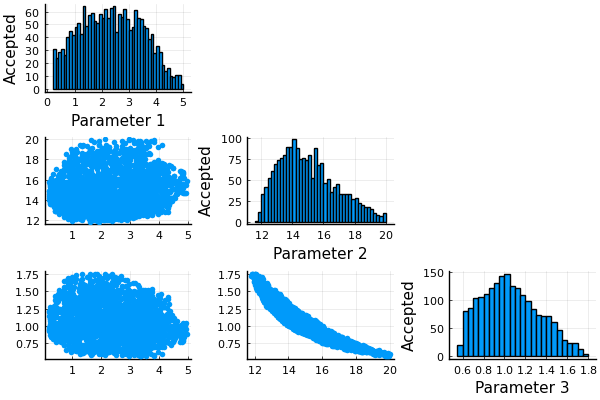

In [6]:
n_design_points = 500
emu_result = EmulatedABCRejection(reference_data, simulator_function, priors, threshold, n_particles, n_design_points;
                                  max_iter=convert(Int, 1e3),
                                  write_progress=false)
plot(emu_result)

# Comparing the resulting posteriors from simulation and emulation

When looking at the approximate posteriors that are from simulation and emulation we are looking to check that they are similar, since emulation's goal is to match simuation.

We can compare these posteriors more quantitatively using the Kullback–Leibler divergence (KLD), which which measures the difference between probability distributions. We estimate the KL from the parameter posterior samples by placing the data into bins and using the discrete estimator. Note this KLD estimate devepend depends on the number of bins and that we are estimating the KLD from the simulation posterior to the emulation one (the KLD is not symmetric).

As one can see the resulting posteriors from simulation and emulation are similar and both center on the correct parameter values.

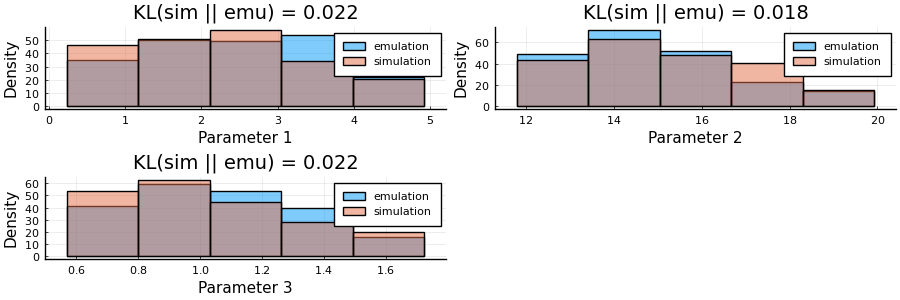

In [7]:
nbins = 5 # The number of bins when plotting the posteriors and calcuating KL(simulation || emulation)

function get_bin_edges(samples1, samples2, nbins)
    alldata = vcat([samples1, samples2]...)
    max_val = maximum(alldata)
    min_val = minimum(alldata)
    eps = 1e-9 # So that edge cases are still binned
    Array(range(min_val-eps, stop=max_val+eps, length=nbins+1))
end

function binned_kl_estimate(samples1, samples2, nbins)
    
    function bindata(data)
        bincounts = fit(Histogram, data, get_bin_edges(samples1, samples2, nbins)).weights
        bincounts/sum(bincounts)
    end
    
    eps = 1e-9 # To avoid division by zero
    binned_samples1 = bindata(samples1)
    binned_samples2 = bindata(samples2)
    sum(binned_samples1 .* log.((binned_samples1.+eps)./(binned_samples2.+eps)))
end

kl_divergences = [binned_kl_estimate(sim_result.population[:,j], emu_result.population[:,j], nbins) for j in 1:3]

plts = Array{Plots.Plot}(undef, length(priors))
for idx in 1:length(plts)
    min_pop_len = min(size(emu_result.population, 1), size(sim_result.population, 1))
    plts[idx] = histogram([emu_result.population[1:min_pop_len,idx] sim_result.population[1:min_pop_len,idx]],
        bins=get_bin_edges(emu_result.population[1:min_pop_len,idx], sim_result.population[1:min_pop_len,idx], nbins),
        label=["emulation" "simulation"], fillalpha=0.5, xlabel="Parameter $idx", ylabel="Density",
        title=@sprintf("KL(sim || emu) = %.3f", kl_divergences[idx]))
end
plot(plts..., size=(900,300))

## Particle Acceptance Criteria
 
`GpABC` offers three criteria according to which a particle can be accepted in emulation-based ABC. Given a trained Gaussian process (GP) emulator, these criteria are:

* `MeanEmulatedParticleSelection`: accept the particle if the mean of the GP evaluated at the particle is less than the threshold.
* `MeanVarEmulatedParticleSelection`: accept the particle if the mean of the GP evaluated at the particle is less than the threshold __and__ the corresponding posterior variance is less than the threshold multiplied by a scaling factor. The scaling factor must be specified by the user - the default value is 1.0.
* `PosteriorSampledEmulatedParticleSelection`: draw a sample from the GP posterior evaluated at the particle. Accept the particle if this sample is less than the threshold. If desired, the GP posterior covariance can be approximated by its diagonal elements - set the `use_diagonal_covariance` field of the `PosteriorSampledEmulatedParticleSelection` struct to `true` to use the approximation. The default is to use the full covariance matrix.

Using `MeanEmulatedParticleSelection` is the simplest option but does not consider the variance of the emulator. This could be problematic if you sample particles in regions where your emulator has high variance. The variance may be high because the emulator has not been trained on particles in that region, in which case accepting those particles could lead to inaccurate posteriors.

Select the criterion using the `emulated_particle_selection` argument to `EmulatedABCRejection` (or `EmulatedABCSMC`). The default is `MeanEmulatedParticleSelection`.

Posteriors from emulated ABC Rejection using the three different acceptance criteria are shown below.

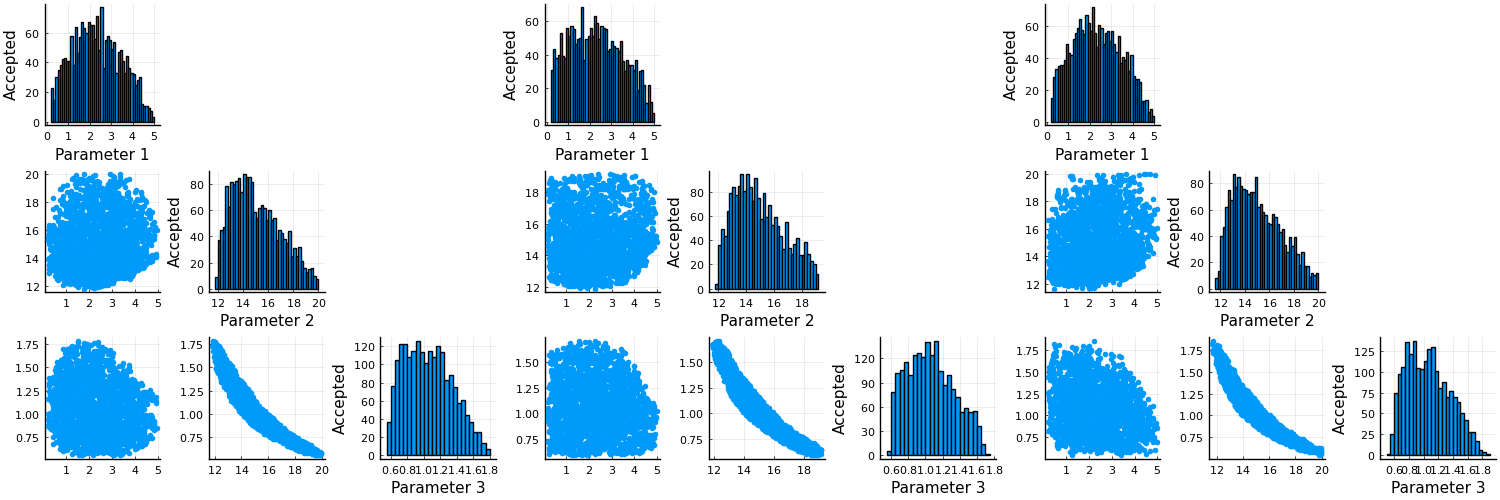

In [8]:
emulation_results = [
    EmulatedABCRejection(reference_data, simulator_function, priors, threshold, n_particles, n_design_points;
            batch_size=100,
            max_iter=convert(Int, 1e3),
            write_progress=false,
            emulated_particle_selection=particle_selection)
    for particle_selection in [MeanEmulatedParticleSelection(), MeanVarEmulatedParticleSelection(), PosteriorSampledEmulatedParticleSelection()]
];

plot([plot(result) for result in emulation_results]..., size=(1500,500), layout=@layout grid(1,3))

Here, the left column of plots uses `MeanEmulatedParticleSelection`, the middle uses `MeanVarEmulatedParticleSelection` (with the defaut scaling factor of 1) and the right-hand plots use `PosteriorSampledEmulatedParticleSelection` (with a full GP posterior covariance). All three criteria lead to similar parameter posteriors in this case.

# ABC-SMC

[ABC-SMC](https://tanhevg.github.io/GpABC.jl/latest/overview-abc/#Simulation-based-ABC-SMC-1) is essentially a sequential set of ABC rejection algorithms, where the population at the previous iteration is used to propose new particles for the current set. The algorithm hones in on the true posterior by incrementally decreasing the threshold at each iteration. The result is that the final population is produced using a much smaller threshold than is possible in ABC Rejection, since the particles proposed according to a previous ABC iteration are more likely to match the data well than those sampled from the priors.

In [9]:
#
# ABC-SMC settings
#
threshold_schedule = [3.0, 2.0, 1.0, 0.5, 0.2];

## Simulation-based ABC-SMC

Similarly to rejection ABC, two algorithms are provided for ABC-SMC: [simulation](https://tanhevg.github.io/GpABC.jl/latest/overview-abc/#Simulation-based-ABC-SMC-1) and [emulation](https://tanhevg.github.io/GpABC.jl/latest/overview-abc/#Emulation-based-ABC-SMC-1) based. Parameters for [`SimulatedABCSMC`](https://tanhevg.github.io/GpABC.jl/latest/ref-abc/#GpABC.SimulatedABCSMC) function are identical to those of `SimulatedABCRejection`. Lower thresholds allow the SMC algorithm to produce much more accurate results than rejection ABC - note the ranges on the X-axes of the histograms below. This, however, is achieved at the expense of a longer run time.

┌ Warning: Simulation reached maximum 20000 iterations before finding 2000 particles - will return 1778
└ @ GpABC /data/.julia/packages/GpABC/o0EN1/src/abc/smc.jl:248
┌ Warning: Simulation reached maximum 20000 iterations before finding 2000 particles - will return 85
└ @ GpABC /data/.julia/packages/GpABC/o0EN1/src/abc/smc.jl:248
┌ Warning: Simulation reached maximum 20000 iterations before finding 2000 particles - will return 66
└ @ GpABC /data/.julia/packages/GpABC/o0EN1/src/abc/smc.jl:248


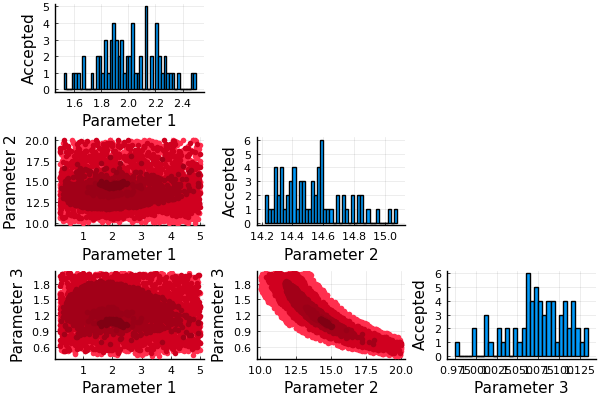

In [10]:
population_colors=["#FF2F4E", "#D0001F", "#A20018", "#990017", "#800013"]
sim_abcsmc_res = SimulatedABCSMC(reference_data,
    simulator_function,
    priors,
    threshold_schedule,
    n_particles; 
    write_progress=false)
plot(sim_abcsmc_res, population_colors=population_colors)

## Emulation-based ABC-SMC

For [`EmulatedABCSMC`](https://tanhevg.github.io/GpABC.jl/latest/ref-abc/#GpABC.EmulatedABCSMC) we have the additional option to retrain the emulator between each population using particles sampled from the most recent population.

┌ Info: GpABC Emulator retraining. Iteration 1: 157 design points with distance below 2.0
└ @ GpABC /data/.julia/packages/GpABC/o0EN1/src/util/emulation_helpers.jl:115
┌ Info: GpABC Emulator retraining. Iteration 1: 50 design points with distance below 1.0
└ @ GpABC /data/.julia/packages/GpABC/o0EN1/src/util/emulation_helpers.jl:115
┌ Info: GpABC Emulator retraining. Iteration 2: 51 design points with distance below 1.0
└ @ GpABC /data/.julia/packages/GpABC/o0EN1/src/util/emulation_helpers.jl:115
┌ Warning: Emulation reached maximum 20 iterations before finding 2000 particles - will return 1156
└ @ GpABC /data/.julia/packages/GpABC/o0EN1/src/abc/smc.jl:323
┌ Info: GpABC Emulator retraining. Iteration 1: 19 design points with distance below 0.5
└ @ GpABC /data/.julia/packages/GpABC/o0EN1/src/util/emulation_helpers.jl:115
┌ Info: GpABC Emulator retraining. Iteration 2: 12 design points with distance below 0.5
└ @ GpABC /data/.julia/packages/GpABC/o0EN1/src/util/emulation_helpers.jl:115
┌

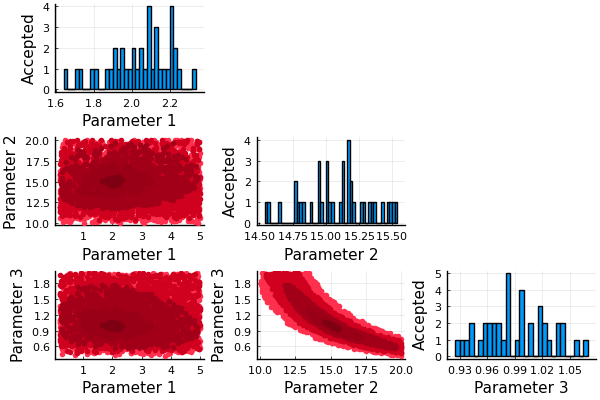

In [11]:
emu_abcsmc_res = EmulatedABCSMC(reference_data,
    simulator_function,
    priors,
    threshold_schedule,
    n_particles,
    n_design_points;
    batch_size=500,
    write_progress=false,
    emulator_retraining = PreviousPopulationThresholdRetraining(n_design_points, 100, 10),
    emulated_particle_selection = MeanVarEmulatedParticleSelection()
    )

plot(emu_abcsmc_res, population_colors=population_colors)

## Summary plot of ABC-SMC emulation and simulation results.

As in the paper. Subplots on the diagonal and below show marginal and joint posterior distributions of parameter estimates in the final ABC-SMC population (simulation in blue and emulation in red). Scatterplots above the diagonal show intermediate ABC-SMC populations with GP emulations; darker colour indicates decreasing threshold Black dashed lines indicate the true parameter values.

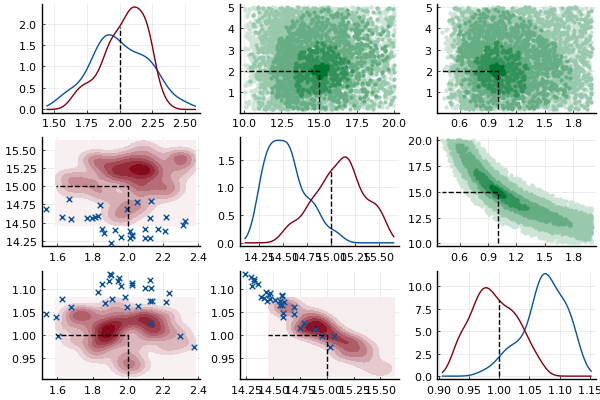

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [12]:
plot(emu_abcsmc_res, sim_abcsmc_res, true_params[param_indices])

## Compare the posteriors

Here we compare the parameter posteriors found by ABC-SMC at the final population. Again we use a binned estimate of the KL divergence to quantify the distance from the simulation posterior to the emulation one.

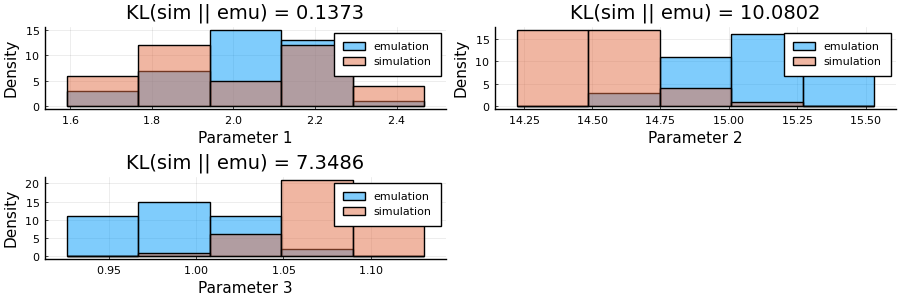

In [13]:
nbins = 5
kl_divergences = [binned_kl_estimate(sim_abcsmc_res.population[end][:,j], emu_abcsmc_res.population[end][:,j], nbins) for j in 1:3]

sim_pop = sim_abcsmc_res.population[end]
emu_pop = emu_abcsmc_res.population[end]
for idx in 1:length(plts)
    min_pop_len = min(size(emu_pop, 1), size(sim_pop, 1))
    plts[idx] = histogram([emu_pop[1:min_pop_len,idx] sim_pop[1:min_pop_len,idx]],
        bins=get_bin_edges(emu_pop[1:min_pop_len,idx], sim_pop[1:min_pop_len,idx], nbins),
        label=["emulation" "simulation"], fillalpha=0.5, xlabel="Parameter $idx", ylabel="Density",
        title=@sprintf("KL(sim || emu) = %.4f", kl_divergences[idx]))
end

plot(plts..., size=(900,300))

Again, the posteriors from emulation both center on the correct parameter values. According to the KLD estimates the first parameter posteriors from simulation and emulation are similar, but the KLD values for the other two parameters indicate that they are not as similar. This is also apparent from the histograms.

# Custom emulator training procedure

The snippet below demonstrates subtyping of `AbstractEmulatorTraining` and usage of `gp_train` for custom emulator training. As mentioned in [`gp_train` reference](https://tanhevg.github.io/GpABC.jl/latest/ref-gp/), all hyperparameters are bounded between $e^{-10}$ and $e^{10}$ during GP training. Suppose this is not good enough for us, and we want control the noise variance $\sigma_n$ more tightly, and let it vary only from 0.001 to 1. In total we need to optimise 5 hyperparameters: signal variance, noise variance, and three length scales (by the number of ODE parameters that we are estimating). $\sigma_n$ is always the last hyperparameter, and the custom optimisation constraints and starting point for it can be specified as follows:

┌ Info: Custom Emulator Training
└ @ Main In[14]:4
┌ Info: GpABC Emulator retraining. Iteration 1: 160 design points with distance below 2.0
└ @ GpABC /data/.julia/packages/GpABC/o0EN1/src/util/emulation_helpers.jl:115
┌ Info: Custom Emulator Training
└ @ Main In[14]:4
┌ Info: GpABC Emulator retraining. Iteration 1: 46 design points with distance below 1.0
└ @ GpABC /data/.julia/packages/GpABC/o0EN1/src/util/emulation_helpers.jl:115
┌ Info: GpABC Emulator retraining. Iteration 2: 49 design points with distance below 1.0
└ @ GpABC /data/.julia/packages/GpABC/o0EN1/src/util/emulation_helpers.jl:115
┌ Info: GpABC Emulator retraining. Iteration 3: 76 design points with distance below 1.0
└ @ GpABC /data/.julia/packages/GpABC/o0EN1/src/util/emulation_helpers.jl:115
┌ Info: Custom Emulator Training
└ @ Main In[14]:4
┌ Warning: Emulation reached maximum 20 iterations before finding 2000 particles - will return 1188
└ @ GpABC /data/.julia/packages/GpABC/o0EN1/src/abc/smc.jl:323
┌ Info: GpABC E

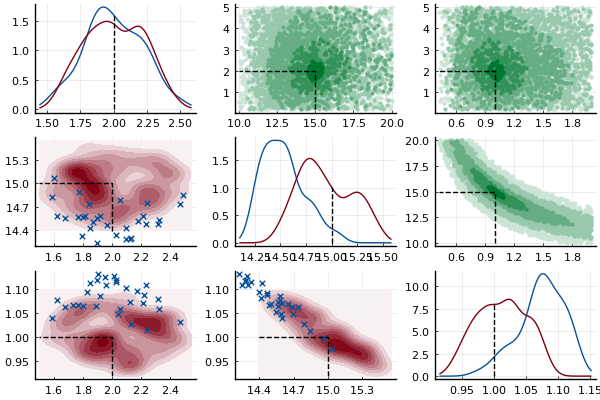

In [14]:
struct CustomEmulatorTraining <: AbstractEmulatorTraining end
import GpABC.train_emulator
function train_emulator(training_x::AbstractArray{T, 2}, y::AbstractArray{T, 2}, emulator_training::CustomEmulatorTraining) where {T<:Real}
    @info "Custom Emulator Training"
    # make sure the starting point is within bounds
    optim_start = vcat(ones(4), 0.5)
    lower_bound = vcat(exp(-10) .* ones(4), 0.001)
    upper_bound = vcat(exp(10) .* ones(4), 1.0)
    gpem = GPModel(training_x=training_x, training_y=y, 
        kernel=SquaredExponentialArdKernel(), 
        gp_hyperparameters=optim_start) 
    gp_train(gpem, hp_lower=lower_bound, hp_upper=upper_bound)
    gpem
end
emu_abcsmc_res_custom = EmulatedABCSMC(reference_data,
    simulator_function,
    priors,
    threshold_schedule,
    n_particles,
    n_design_points;
    batch_size=500,
    write_progress=false,
    emulator_retraining = PreviousPopulationThresholdRetraining(n_design_points, 100, 10),
    emulated_particle_selection = MeanVarEmulatedParticleSelection(),
    # this instructs the ABC-SMC procedure to use the custom training implemented above
    emulator_training=CustomEmulatorTraining() 
    )
plot(emu_abcsmc_res_custom, sim_abcsmc_res, true_params[param_indices])